# Modeling of the nickel supply chain to battery electric vehicles 

## 1) Load ODYM and other data management/visualization packages

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
from tqdm import tqdm
import seaborn as sns
import seaborn 
seaborn.set()
import matplotlib
matplotlib.style.use('ggplot')

# add ODYM module directory to system path, relative
MainPath = os.path.join('..', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join('..', 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(),'..', 'docs', 'files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename  = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)


## 2) Load system classification, index table, and data 

With the model imported, we can now set up the system definition. The 'classical' elements of the system definition in MFA include: The processes, flows, and stocks, the material, the region, and the time frame studied. Next to these elements, ODYM features/requires the following elements to be specified:
+ The list of chemical elements considered (Ni in this case though it might also be relevant to track S at a future point)
+ The classification(s) of the system variables (stocks and flows): Which materials, products, regions, or waste groups are considered? 
+ An index letter to quickly/directly access a model aspect.
+ A dictionary of model parameters.

For all these items ODYM has a specific structure, which are coded in the model config file ODYM_Config_Tutorial6.xlsx and read using a set of customized functions.

In [2]:
#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Ni_Supply.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Ni_Supply.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


INFO (<ipython-input-2-e4b44353f45b> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 9. Check if all classifications are present. If yes, you are good to go!


ODYM_Ni_Supply


With the code below, the model classifications are created from the info read with msf.ParseClassificationFile_Main.
The index table is created with the info read with msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog) .

In [3]:
Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

INFO (<ipython-input-3-9687dc4c0795> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-3-9687dc4c0795> <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO (<ipython-input-3-9687dc4c0795> <<module>>): Define index table dataframe.


That dictionary of classifications enters the index table defined for the system. The index table lists all aspects needed and assigns a classification and index letter to each aspect.

In [4]:
Model_Duration

151

In [5]:
IndexTable

,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Time,Model time,Time,<ODYM_Classes.Classification object at 0x7f848...,t,151
Element,chemical elements,Element,<ODYM_Classes.Classification object at 0x7f848...,e,1
Unity,"trivial classification, 1 entry only",Unity,<ODYM_Classes.Classification object at 0x7f848...,1,1
Supply_Scenario,Scenarios of Supply Chain Aspects,Scenario,<ODYM_Classes.Classification object at 0x7f848...,S,1
NoB_Scenario,Non Battery Demand Scenarios,Scenario,<ODYM_Classes.Classification object at 0x7f848...,N,3
LiB_Scenario,Scenarios of Demand to LiB,Scenario,<ODYM_Classes.Classification object at 0x7f848...,L,7
Rec_Scenario,Scenarios of LiB recyclng rates,Scenario,<ODYM_Classes.Classification object at 0x7f848...,R,4


In [6]:
# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items)
NL = len(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items)
NN = len(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items)

With the index table in place, the model parameters can now be read. Note that the parameters could have data outside the model range and the model will only read what is relevant

In [7]:
ParameterDict = {}
mo_start = 0 # set mo for re-reading a certain parameter
for mo in range(mo_start,len(PL_Names)):
    #mMParPath = os.path.join(os.path.abspath(os.path.join(ProjectSpecs_Path_Main, '.')), 'ODYM_RECC_Database', PL_Version[mo])
    ParPath = os.path.join(DataPath, PL_Names[mo] + '_' + PL_Version[mo])
    Mylog.info('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values = msf.ReadParameterV2(ParPath, PL_Names[mo], PL_IndexStructure[mo], PL_IndexMatch[mo],
                                         PL_IndexLayer[mo], MasterClassification, IndexTable,
                                         IndexTable_ClassificationNames, ScriptConfig, Mylog, False)
    ParameterDict[PL_Names[mo]] = msc.Parameter(Name=MetaData['Dataset_Name'], ID=MetaData['Dataset_ID'],
                                                UUID=MetaData['Dataset_UUID'], P_Res=None, MetaData=MetaData,
                                                Indices=PL_IndexStructure[mo], Values=Values, Uncert=None,
                                                Unit=MetaData['Dataset_Unit'])
    Mylog.info('Current parameter file UUID: ' + MetaData['Dataset_UUID'])
    Mylog.info('_')
Mylog.info('Reading of parameters finished.')

INFO (<ipython-input-7-498ae586858a> <<module>>): Reading parameter DC_Refinery_Production
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 201 values was read from file for parameter DC_Refinery_Production.
INFO (ODYM_Functions.py <ReadParameterV2>): 151.0 of 151 values for parameter DC_Refinery_Production were assigned.
INFO (<ipython-input-7-498ae586858a> <<module>>): Current parameter file UUID: 
INFO (<ipython-input-7-498ae586858a> <<module>>): _
INFO (<ipython-input-7-498ae586858a> <<module>>): Reading parameter Matte_Smelting_Cap
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 201 values was read from file for parameter Matte_Smelting_Cap.
INFO (ODYM_Functions.py <ReadParameterV2>): 151.0 of 151 values for parameter Matte_Smelting_Cap were assigned.
INFO (<ipython-input-7-498ae586858a> <<module>>): Current parameter file UUID: 
INFO (<ipython-input-7-498ae586858a> <<module>>): _
INFO (<ipython-input-7-498ae586858a> <<module>>): Reading parameter FeNi_Production
INFO

INFO (ODYM_Functions.py <ReadParameterV2>): 453.0 of 453 values for parameter Baseline_Metal_Non_Stainless were assigned.
INFO (<ipython-input-7-498ae586858a> <<module>>): Current parameter file UUID: 
INFO (<ipython-input-7-498ae586858a> <<module>>): _
INFO (<ipython-input-7-498ae586858a> <<module>>): Reading parameter Baseline_Sulphate_to_NoB
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 603 values was read from file for parameter Baseline_Sulphate_to_NoB.
INFO (ODYM_Functions.py <ReadParameterV2>): 453.0 of 453 values for parameter Baseline_Sulphate_to_NoB were assigned.
INFO (<ipython-input-7-498ae586858a> <<module>>): Current parameter file UUID: 
INFO (<ipython-input-7-498ae586858a> <<module>>): _
INFO (<ipython-input-7-498ae586858a> <<module>>): Reading parameter NoB_Recycling_Rate
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 603 values was read from file for parameter NoB_Recycling_Rate.
INFO (ODYM_Functions.py <ReadParameterV2>): 453.0 of 453 values for para

Print some core data elements for info:

In [8]:
ScriptConfig

{'Model Setting': 'Ni_Supply',
 'Name of model setting': 'ODYM_Ni_Supply',
 'Description': 'Scenario analysis of dispersion of steel into different applications.',
 'Name of model script used': 'ODYM_Ni_Supply',
 'Version of master classification': 'ODYM_Classifications_Ni_Supply',
 'Version of ODYM Classes': 'V01',
 'Version of ODYM Functions': 'V01',
 'Logging_Verbosity': 'DEBUG'}

In [9]:
PrL_Name

['Uncaptured',
 'Sulphide Mining',
 'Laterite Mining',
 'Direct Concentrate Refining',
 'Matte Smelting',
 'Fe-Ni Smelting',
 'Laterite Leaching',
 'NPI Smelting',
 'Sulphidization FeNi',
 'Sulphidization NPI',
 'Matte Market',
 'Metal Refining',
 'Metal Market and Stockpile',
 'Precurser CAM',
 'Cathode Active Material Production',
 'EV Stock',
 'Cathode EoL Collection',
 'Non-Battery Production',
 'Non-Battery Use',
 'Mixed EoL NoB Collection',
 'Copper/Cobalt Production',
 'Lanfill',
 'Carbon Scrap Market']

We can now define our MFA system: 

In [10]:
Ni_Supply_System = msc.MFAsystem(Name = 'Ni_Supply_System', 
                      Geogr_Scope = 'World', 
                      Unit = 'kt', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = ParameterDict, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

# Add processes to system
for m in range(0, len(PrL_Number)):
    Ni_Supply_System.ProcessList.append(msc.Process(Name = PrL_Name[m], ID   = PrL_Number[m]))

## 3) Define MFA system
This system has a name, a geographical scope, a system-wide unit, a time frame, an index table with all aspects defined, and a list of chemical elements considered.


The system describes the mining and processing of nickel products to their various first and end uses, as well as their EoL processes such as recycling and disposal. The various stages in the value chain are defined as processes, with flows of nickel containing goods represented between the processes. The process is diagrammed below using MFA methodology

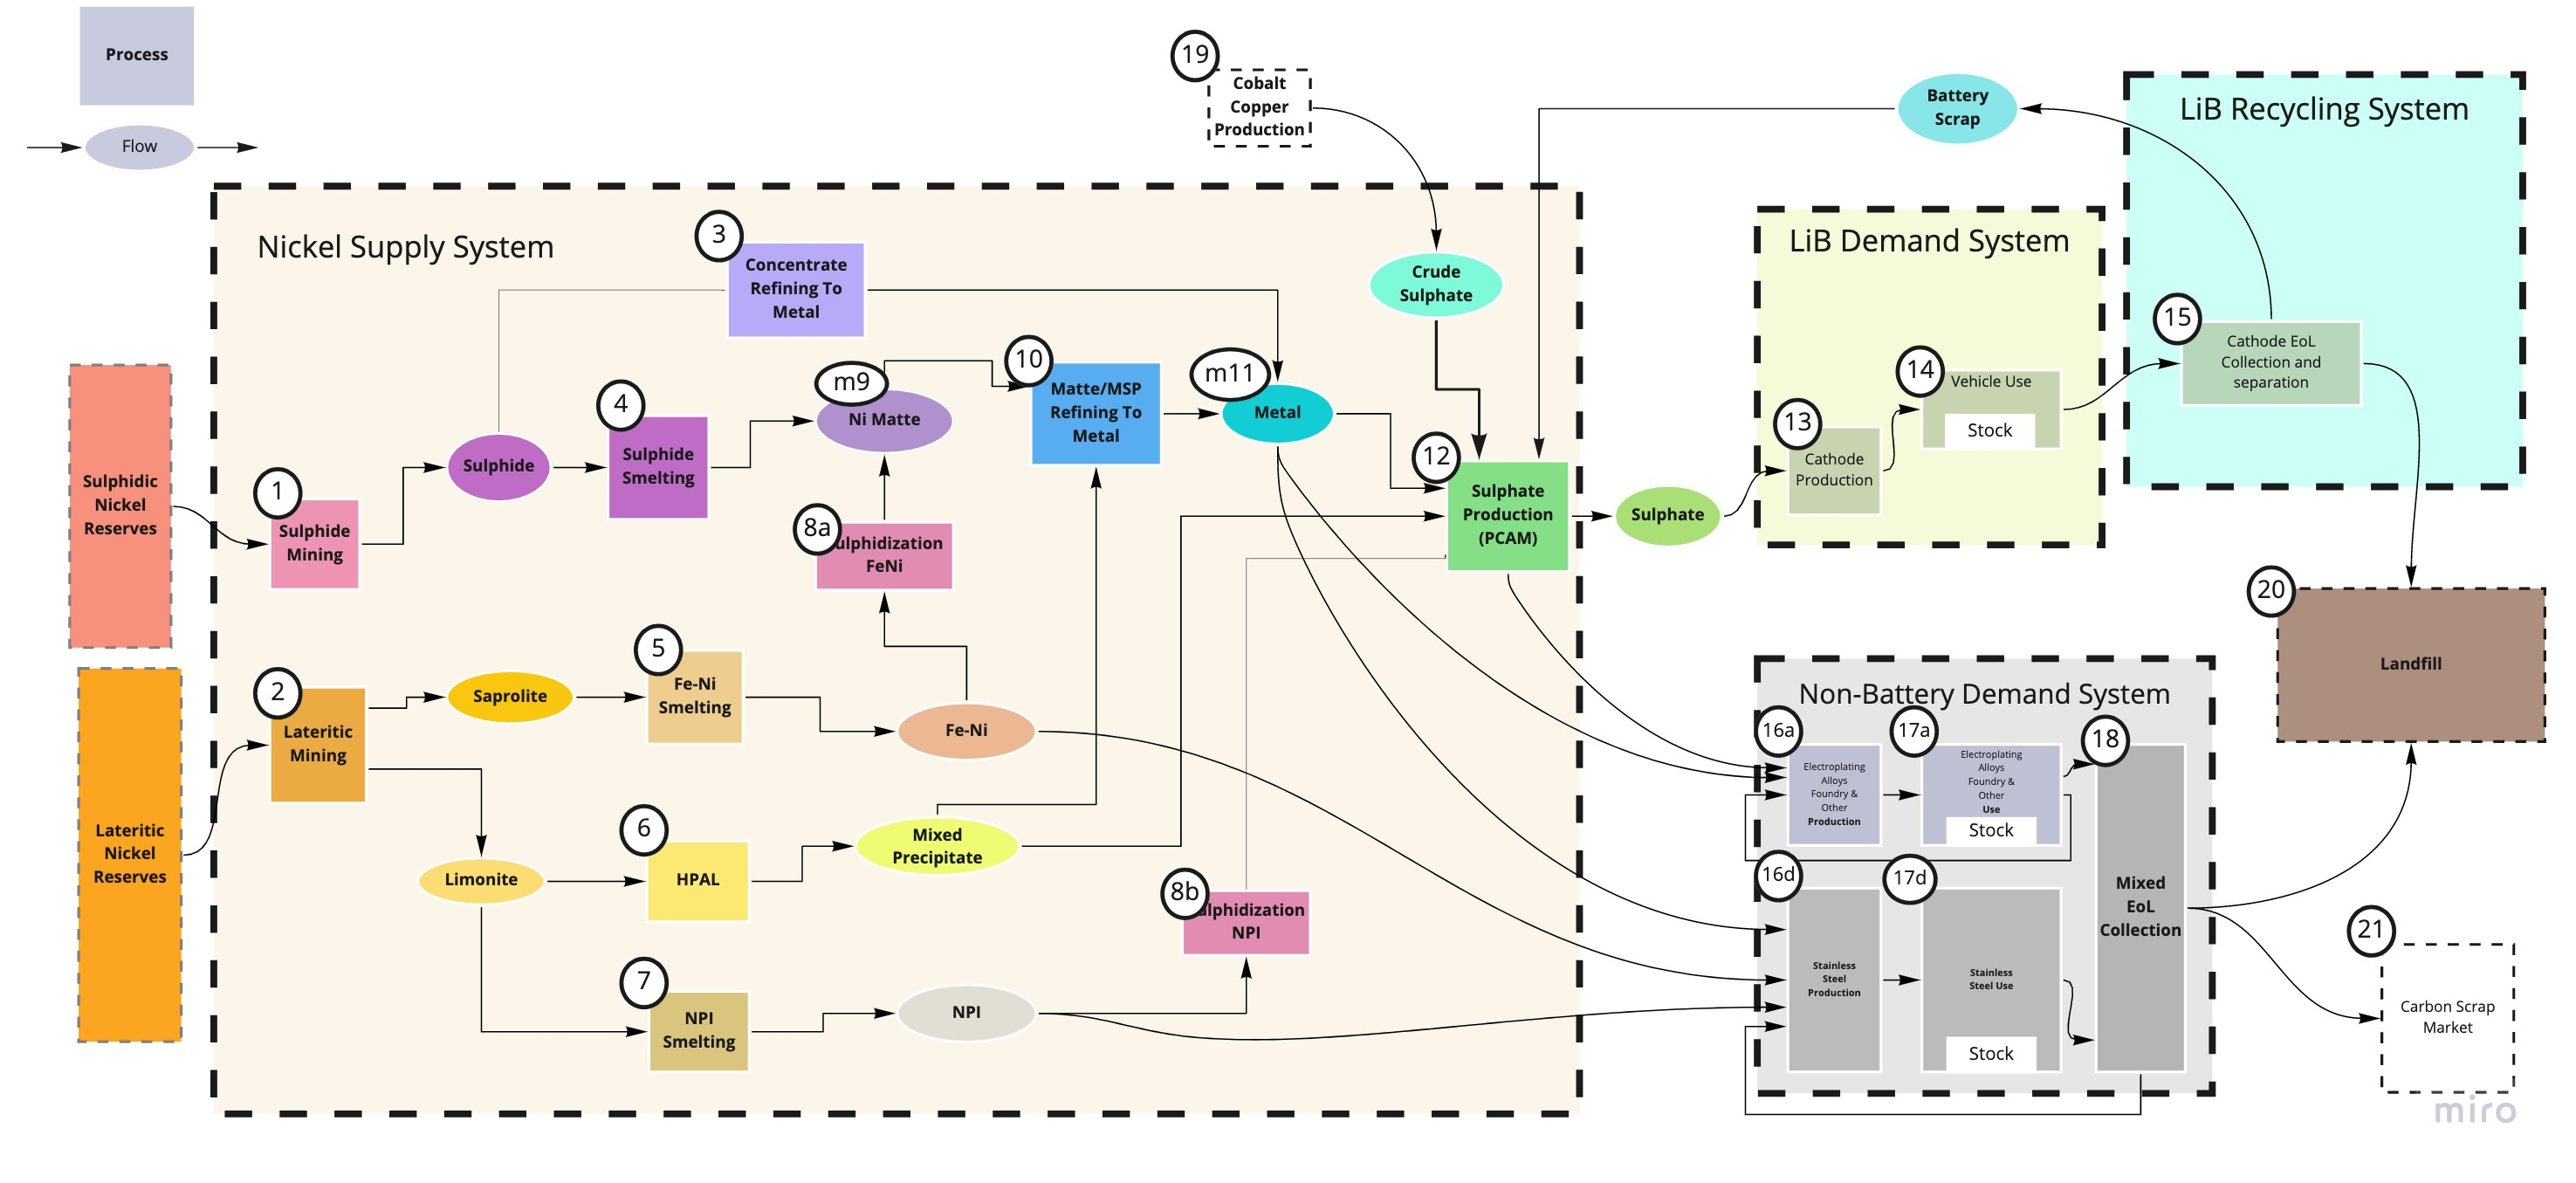

In [11]:
from IPython.display import Image
Image("Nickel Flow Diagram - Full Model.jpg")

As is visualized in the image. The total supply chain is divided into 4 component systems, which I have separated according to different categories of stakeholders as they relate to the Battery-nickel value chain.
Firstly the Ni supply system, which contains all processes of virgin ore extraction and processing to first ni products in first use. After that are the lithium ion battery (LiB) and Non-Battery (NoB) demand systems, which detail the production and use phases of nickel in products. The NoB demand system has the EoL and Recycling phases included in the system, whereas the LiB case has these very downsteam aspects separated into it's own LiB recycling system. 
The separation into these systems is reflected in the set of scenarios which affect the parameters of the various flows within the system. Flows and processes in the Ni Supply System are going to be primarily affected by the parameters which can be influenced by actors in this portion of the system. Flows within one system are of course influenced by actions taken in other parts of the system. This is the reason for a systemic analysis. However, this separation is deemed to be useful in understanding the levers available to certain stakeholders.
These divisions are of course only a useful approximation, as is a model itself. The lines could meaninfully be drawn along other topographical features of the landscape to emphasize different aspects of possible influence

### Initializing flows

In [12]:
# order of Scenarios is S,N,L,R,t - Saturday Night Live Reruns, in your local region and time
# a justification for this ordering is that it is the order of flow from left to right (assuming that we put NoB demand before LiB demand)

# All flows shown on the above diagram initialized below, and have different dimesnions depending on the number of relevant Scenarios that they are influenced by
Ni_Supply_System.FlowDict['F_0_1'] = msc.Flow(Name = 'Sulphide Ore Extraction', P_Start = 0, P_End = 1,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_0_2'] = msc.Flow(Name = 'Latrite Ore Extraction', P_Start = 0, P_End = 2,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_1_3'] = msc.Flow(Name = 'Sulphate Concentrate to DC refining', P_Start = 1, P_End = 3,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_1_4'] = msc.Flow(Name = 'Sulphate Concentrate to Matte Smelting', P_Start = 1, P_End = 4,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_1_0'] = msc.Flow(Name = 'Mine Tailings', P_Start = 1, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_2_0'] = msc.Flow(Name = 'Laterite Mine Tailings', P_Start = 2, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_2_5'] = msc.Flow(Name = 'Saprolite to Fe-Ni Smelting', P_Start = 2, P_End = 5,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_2_6'] = msc.Flow(Name = 'Limonite to Leaching', P_Start = 2, P_End = 6,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_2_7'] = msc.Flow(Name = 'Limonite to NPI Smelting', P_Start = 2, P_End = 7,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_3_0'] = msc.Flow(Name = 'DC Refining Tailings', P_Start = 3, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_3_m11'] = msc.Flow(Name = 'DC Refining Tailings', P_Start = 3, P_End = 11,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_4_0'] = msc.Flow(Name = 'Matte Smelting Slag', P_Start = 4, P_End = 0,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_4_m9'] = msc.Flow(Name = 'Matte Smelter Production', P_Start = 4, P_End = 9,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_5_0'] = msc.Flow(Name = 'FeNi_Smelter_Slag', P_Start = 5, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_5_8a'] = msc.Flow(Name = 'FeNi to Reduction Roasting', P_Start = 5, P_End = 8,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_5_16'] = msc.Flow(Name = 'FeNi-NOB', P_Start = 5, P_End = 16,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_6_0'] = msc.Flow(Name = 'Leach Tailings', P_Start = 6, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_6_10additional'] = msc.Flow(Name = 'Leach Intermediates to Trad Refining', P_Start = 6, P_End = 10,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_6_10original'] = msc.Flow(Name = 'Leach Intermediates to Trad Refining', P_Start = 6, P_End = 10,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_6_12'] = msc.Flow(Name = 'Leach intermediates to PCAM production', P_Start = 6, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_7_0'] = msc.Flow(Name = 'NPI Slag', P_Start = 7, P_End = 0,
                                            Indices = 'S,N,L,t', Values=None)
Ni_Supply_System.FlowDict['F_7_12'] = msc.Flow(Name = 'NPI->matte->PCAM production', P_Start = 7, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_7_16'] = msc.Flow(Name = 'NPI to NOB production', P_Start = 7, P_End = 16,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_8a_0'] = msc.Flow(Name = 'Reduction Roast Losses', P_Start = 8, P_End = 0,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_8a_m9'] = msc.Flow(Name = 'Reduction Roasting Matte Production', P_Start = 8, P_End = 9,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_m9_10'] = msc.Flow(Name = 'Matte to Trad Refining', P_Start = 9, P_End = 10,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_m9_12'] = msc.Flow(Name = 'Matte from Market to PCAM', P_Start = 9, P_End = 12,
                                            Indices = 'S,t', Values=None)
Ni_Supply_System.FlowDict['F_10_m11'] = msc.Flow(Name = 'Refinery Production', P_Start = 10, P_End = 11,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_m11_12'] = msc.Flow(Name = 'Class 1 metal to PCAM production', P_Start = 11, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_m11_16min'] = msc.Flow(Name = 'Class 1 metal to NOB production', P_Start = 11, P_End = 16,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_m11_16additional'] = msc.Flow(Name = 'Class 1 metal to NOB production', P_Start = 11, P_End = 16,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_12_13'] = msc.Flow(Name = 'Sulphate to Cathode Production', P_Start = 12, P_End = 13,
                                            Indices = 'L,t', Values=None)
Ni_Supply_System.FlowDict['F_12_16'] = msc.Flow(Name = 'Sulphate to NOB uses', P_Start = 12, P_End = 16,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_13_14'] = msc.Flow(Name = 'Cathode Active Materials to EV Use', P_Start = 13, P_End = 14,
                                            Indices = 'L,t', Values=None)
Ni_Supply_System.FlowDict['F_14_15'] = msc.Flow(Name = 'Outflows of EoL Vehicles to Collection', P_Start = 14, P_End = 15,
                                            Indices = 'L,t', Values=None)
Ni_Supply_System.FlowDict['F_15_12'] = msc.Flow(Name = 'Recycled Battery Scrap to PCAM production', P_Start = 15, P_End = 12,
                                            Indices = 'L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_15_20'] = msc.Flow(Name = 'EOL LIB to Landfill', P_Start = 15, P_End = 20,
                                            Indices = 'L,R,t', Values=None)
Ni_Supply_System.FlowDict['F_16_17'] = msc.Flow(Name = 'NoB Production', P_Start = 16, P_End = 17,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_17_18'] = msc.Flow(Name = 'NoB outflows', P_Start = 17, P_End = 18,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_18_16'] = msc.Flow(Name = 'NOB to NOB Recycling', P_Start = 18, P_End = 16,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_18_21'] = msc.Flow(Name = 'NOB to Carbon Scrap Market', P_Start = 18, P_End = 21,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_18_20'] = msc.Flow(Name = 'NOB to Landfill', P_Start = 18, P_End = 20,
                                            Indices = 'N,t', Values=None)
Ni_Supply_System.FlowDict['F_19_12'] = msc.Flow(Name = 'Crude Ni Sulphate', P_Start = 19, P_End = 12,
                                            Indices = 'S,t', Values=None)


''' Stocks and Stock Changes'''

Ni_Supply_System.StockDict['S_m9']   = msc.Stock(Name = 'Matte Stock', P_Res = 9, Type = 0,
                                              Indices = 'S,N,L,t', Values=None)
Ni_Supply_System.StockDict['dS_m9']  = msc.Stock(Name = 'Matte Stock Change', P_Res = 9, Type = 0,
                                              Indices = 'S,N,L,t', Values=None)
Ni_Supply_System.StockDict['S_m11']   = msc.Stock(Name = 'Metal Stock', P_Res = 11, Type = 0,
                                                  Indices = 'S,N,L,t', Values=None)
Ni_Supply_System.StockDict['dS_m11']  = msc.Stock(Name = 'Metal Stock Change', P_Res = 11, Type = 0,
                                              Indices = 'S,N,L,t', Values=None)
Ni_Supply_System.StockDict['dS_14']  = msc.Stock(Name = 'Ni in Cathode Stock Change', P_Res = 14, Type = 0,
                                              Indices = 'L,t', Values=None)
Ni_Supply_System.StockDict['S_14']  = msc.Stock(Name = 'Ni in Cathode In Use Stock', P_Res = 14, Type = 0,
                                              Indices = 'L,t', Values=None)
Ni_Supply_System.StockDict['dS_17']  = msc.Stock(Name = 'Ni in NoB stock change', P_Res = 17, Type = 0,
                                              Indices = 'N,t', Values=None)
Ni_Supply_System.StockDict['S_17']  = msc.Stock(Name = 'Ni in NoB Stock', P_Res = 17, Type = 0,
                                              Indices = 'N,t', Values=None)

Ni_Supply_System.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.
Ni_Supply_System.Initialize_StockValues() # Assign empty arrays to flows according to dimensions.

In [13]:
# Check whether flow value arrays match their indices, etc. See method documentation.
Ni_Supply_System.Consistency_Check() 

(True, True, True)

In [14]:
# model_run list of years is useful for plotting
model_run=Ni_Supply_System.IndexTable['Classification']['Time'].Items

In [15]:
# Stops list of detlails apprearing when making plots:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

### Define Loss Rates

In [16]:
#Defining the process losses happens here though in the future it might be relevant to have an external parameter sheet

Sulphide_Mining_Losses = 0.05
Laterite_Mining_Losses = 0.05
Direct_Concentrate_Refining_Losses = 0.05
Matte_Smelting_Losses = 0.05
FeNi_Smelting_Losses = 0.05
Laterite_Leaching_Losses = 0.05
NPI_Smelting_Losses = 0.05
Reduction_Roasting_Losses = 0.05
Metal_Refining_Losses = 0.01
Matte_Smelting_Losses = 0.05
PCAM_Production_Losses = 0.005
Carbon_Scrap_Losses = 0.18

Also a list of max capacities to be used in the short term but hopefully updated from a better source later on

In [17]:
'''Capacities from facilities list 2019 values'''
Cap_3_on = 50
Cap_5_on = 482
Cap_6_on = 321.6
Cap_7_on = 701
Cap_10_on=1082+45.24
Cap_on = Cap_3_on +Cap_5_on + Cap_6_on + Cap_7_on + Cap_10_on
Cap_5_off = 71
Cap_6_off = 20.2
Cap_7_off = 71
Cap_10_off = 234.3
Cap_off = Cap_5_off + Cap_6_off + Cap_7_off + Cap_10_off 
Cap_exist = Cap_on + Cap_off

## 4) Calculate flows from parameters and system definition

### 4.1) LiB demand system

The $\textbf{LiB demand}$ for Ni Sulphate is driven by the demand of Ni to Cathode production. This demand is modelled externally by Fernando in his stock driven model. I have borrowed four of his demand curves based on different scenario conditions, and also added one taken from Roskill's JRC report on Nickel bottlenecks to battery consumption.
LiB demand only has the dimension of the LiB scencarios, marked with an L. 

There are 7 scenarios to the demand for new Ni to LiB manufacturing. 
The first of these scenarios is taken from the figures in the Roskill JRC report and is therefore named the Roskill scenario.
Four of the scenarios are based on a stock driven model of the global vehicle fleet representing faster or slower penetrations of electric vehicles with battery cathode chemistries with higher or lower average nickel contents
LFP Slow = slow penetration of low nickel cathodes
LFP Fast = fast penetration of low nickel cathodes
NCX Slow = slow penetration of high nickel cathodes
NCX Fast = fast penetration of high nickel cathodes
Two scenarios posit the adoption in 2030 of an advanced disruptive technology which decreases the requirement of Ni to the Cathodes
These scenarios follow the Roskill and the NCX fast numbers before 2030 wherepon there is a 25% per year decrease in Ni demand to cathodes to a baseline of 280 and 200 kT Ni per year (t-1 * .75 + 70) and (t-1 * .75 + 70) respectively

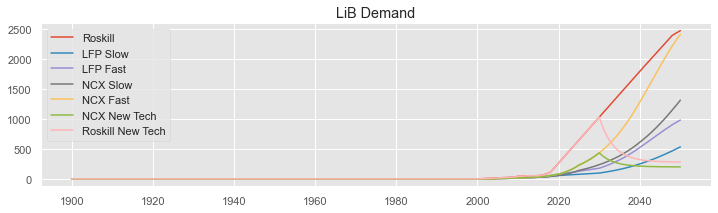

In [18]:
CellFlow = Ni_Supply_System.FlowDict['F_13_14']
Ni_Supply_System.FlowDict['F_13_14'].Values = Ni_Supply_System.ParameterDict['LiB_Ni_Demand'].Values

plt.figure(figsize=(12,3))        
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
    plt.title('LiB Demand')
    plt.plot(model_run, CellFlow.Values[i,:], label='{}'.format(n))

plt.legend()


In order to make the scenarios consistent the vehicles were given a set lifetime to calculate the outflows. 

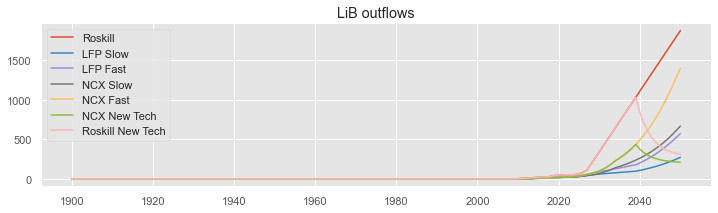

In [19]:
#outflows from EV
Ni_Supply_System.FlowDict['F_14_15'].Values = Ni_Supply_System.ParameterDict['LiB_Ni_Outflows'].Values
plt.figure(figsize=(12,3))        
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
    plt.title('LiB outflows')
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_14_15'].Values[i,:], label='{}'.format(n))

plt.legend()

Stocks of Ni in the in use vehicle process are calculated by simple inflows minus outflows

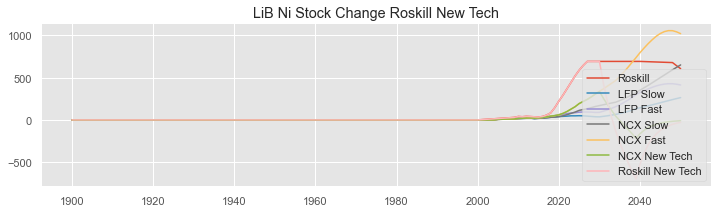

In [20]:
Ni_Supply_System.StockDict['dS_14'].Values  = Ni_Supply_System.FlowDict['F_13_14'].Values - Ni_Supply_System.FlowDict['F_14_15'].Values

plt.figure(figsize=(12,3))        
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
    plt.title('LiB Ni Stock Change {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.StockDict['dS_14'].Values[i,:], label='{}'.format(n))

plt.legend()

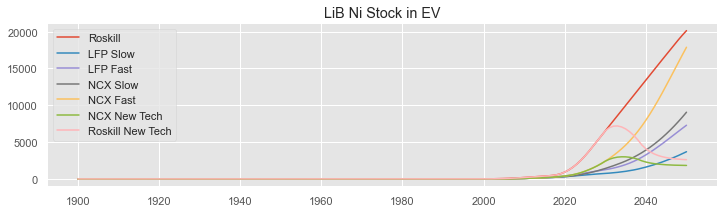

In [21]:
for L in range(0,NL):
    for t in range(1,Nt):
        Ni_Supply_System.StockDict['S_14'].Values[L,t]   = Ni_Supply_System.StockDict['S_14'].Values[L,t-1] + Ni_Supply_System.StockDict['dS_14'].Values[L,t]
#plot stock and stock change
plt.figure(figsize=(12,3))        
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
    plt.title('LiB Ni Stock in EV')
    plt.plot(model_run, Ni_Supply_System.StockDict['S_14'].Values[i,:], label='{}'.format(n))

plt.legend()

### 4.2) LiB recycling system

There are four recycling rate scenarios which are self explanatory enough as:
Low Slow - a gradual increase to 80% recycling over 20 years starting 2020
Low Fast - a gradual increase to 80% recycling over 10 years starting 2020
High Slow - a gradual increase to 95% recycling over 20 years starting 2020
High Fast - a gradual increase to 95% recycling over 10 years starting 2020

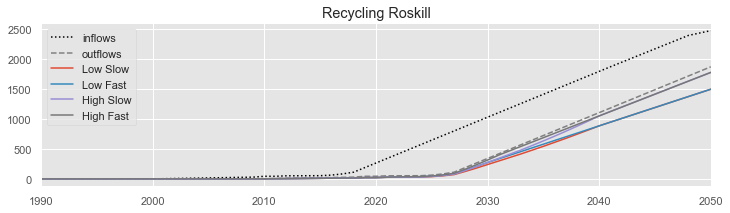

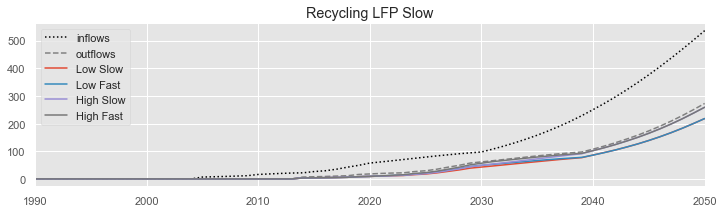

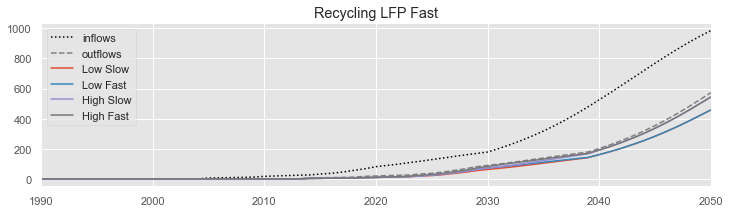

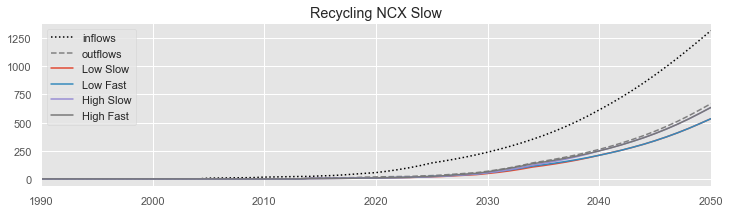

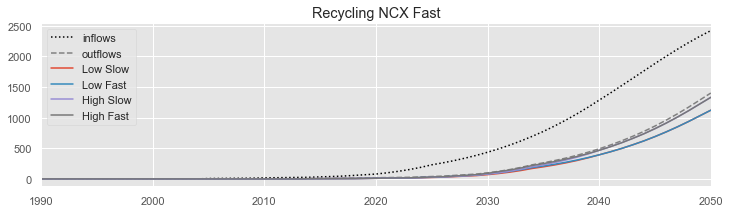

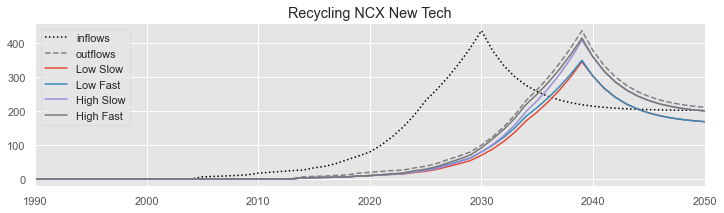

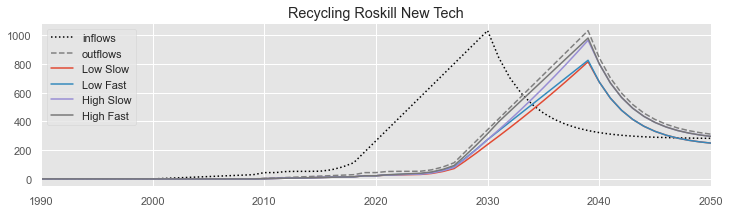

In [22]:
# the recycled battery to PCAM is the outflow per scenario, multiplied by the recycling rate parameter.
for R in range(NR):
    for L in range(NL):
        Ni_Supply_System.FlowDict['F_15_12'].Values[L,R,:] = Ni_Supply_System.ParameterDict['LiB_Recycling_Rate'].Values[R,:] * Ni_Supply_System.FlowDict['F_14_15'].Values[L,:]
        Ni_Supply_System.FlowDict['F_15_20'].Values[L,R,:] = Ni_Supply_System.FlowDict['F_14_15'].Values[L,:] - Ni_Supply_System.FlowDict['F_15_12'].Values[L,R,:]
# visualise the four outflow scenarios under different recycling conditions
   
for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
    plt.figure(figsize=(12,3))    
    plt.title('Recycling {}'.format(ln))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_13_14'].Values[L,:],color='black', ls=':', label='inflows')
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_14_15'].Values[L,:],color='grey', ls='--', label='outflows')
    for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):
        plt.plot(model_run, Ni_Supply_System.FlowDict['F_15_12'].Values[L,R,:], label='{}'.format(rn))
    plt.legend(loc='upper left')
    plt.xlim(1990,2050)    

### 4.3) Non-Battery Demand System

Here we take again the exernal parameters to define the demand for Nickel to the non battery system.

We will start with the total amount of Ni demanded to the NoB System. 
Because the recycling flows of NoB products are generally excluded from the picture when taking the demand flows into account, making a full picture of the demand for nickel will have to be cobbled together from a number of steps. 
Firstly, we will take total first use demand, which is reported historically and commonly forecasted
The Historic data on Ni Production is here taken from RNG global Ni Production Data from 1975 to 2008. Thereafter the Roskill End Use Report fills in the picture from 2009-2018. 
There are also Data sources from the BGS and from Barbara Rech's work that have historic nickel production which should be compared with this as well as Roskill data from 1965.
After 2040 the model uses a simple 2% yoy growth of new material, A very conservative number
The forecast for Ni Demand of new materials has two scenarios, one from Roskill's prediction 

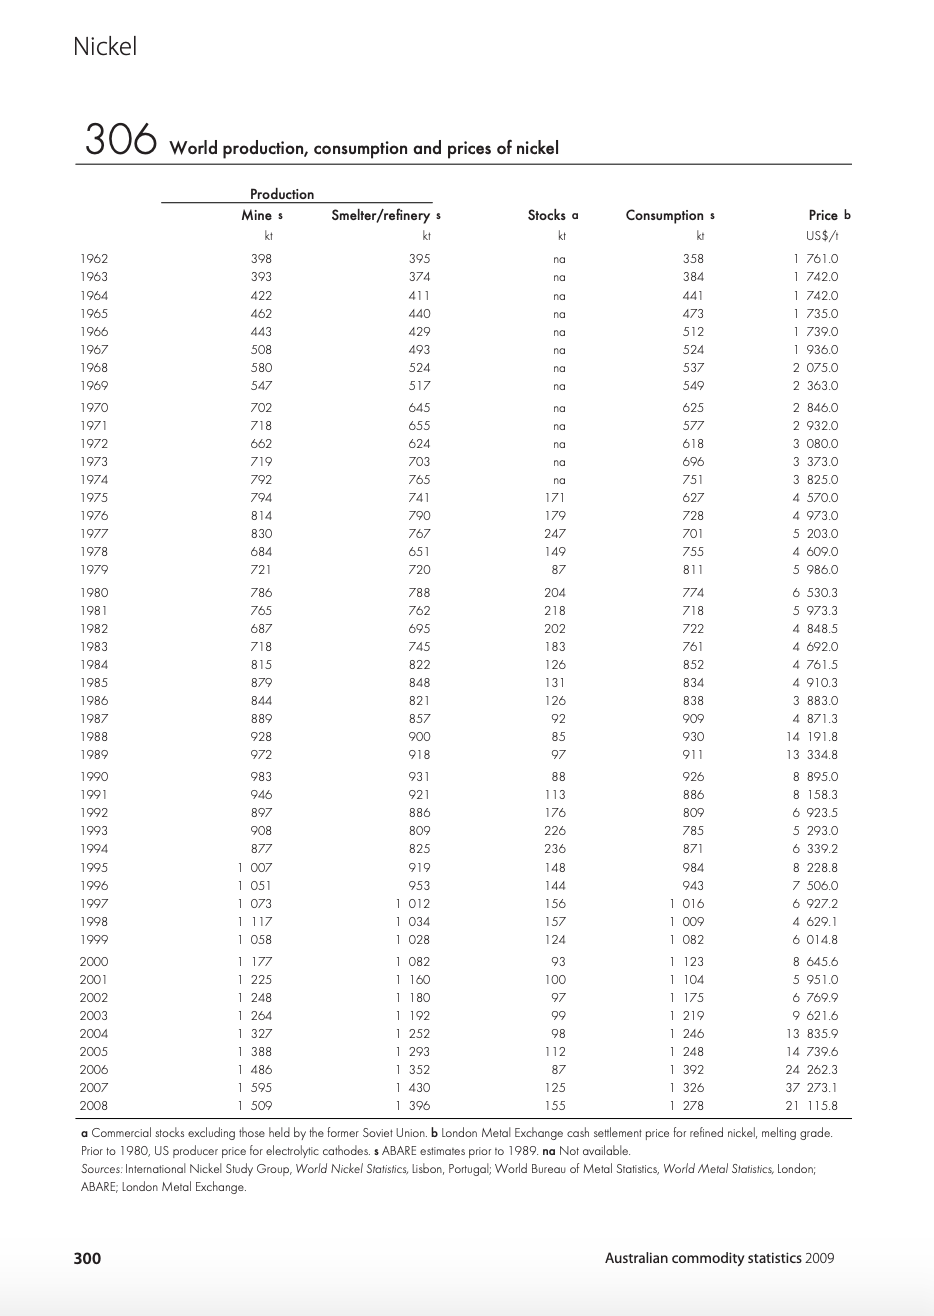

In [23]:
Image("Historic Production.png")

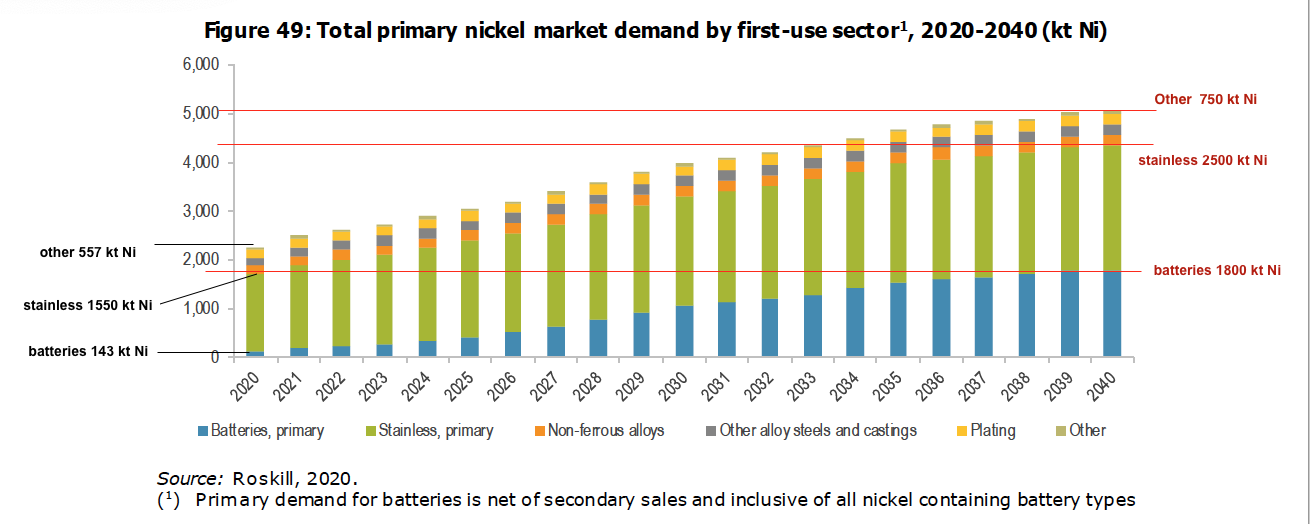

In [24]:
Image("Roskill_NoB_Demand.png")

The forecast below from the Wood Mackenzie market report to Giga Metals shows the 2018 picture as about 2600 kt total demand of which about 1000 is supplied by scrap recycling. Leaving a number consisten with the 1550 value given by Roskill. By 2040, the total Demand has climbed to for stainless has climed to 3200 less 1300 from scrap, leaving a more conservative 1900 kt than the Roskill picture.

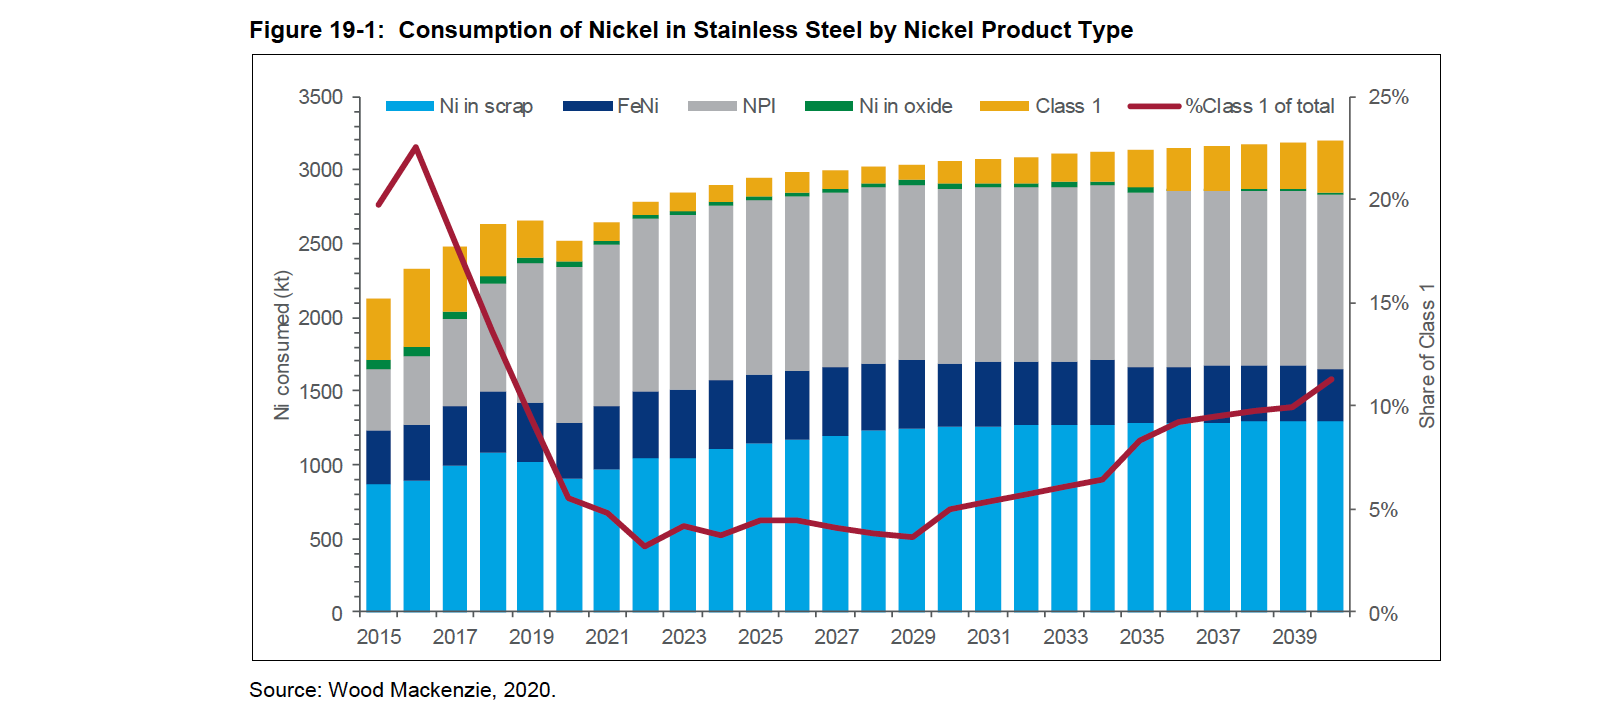

In [25]:
Image("Wood Mac Stainless Demand.png")

In [26]:
(310+210+100+100+75) 

795

Meanwhile, other uses by wood mac sum to (240+160+60+80+90) 630  and the 2040 values (310+210+100+100+75) 795 which is in line with the Roskill numbers. Wood mac shows 300 units of class 1 being used in stainless production in 2018, but has that number declining.

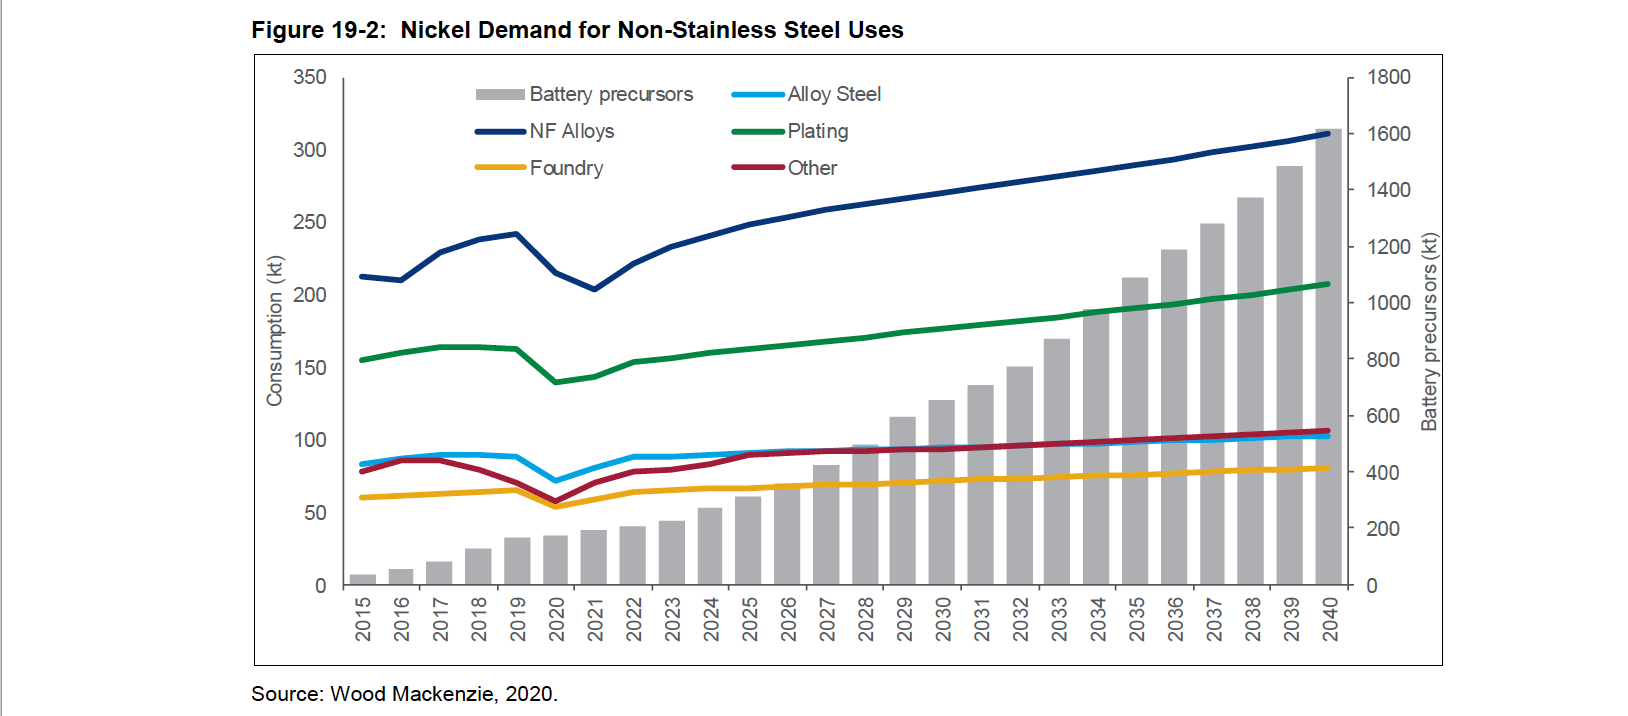

In [27]:
Image("Wood Mac Non Stainless Demand.png")

The above provides a picture of the demand for new nickel products. However, from a demand driven perspective we want to know the total demand including supply from reuse of scrap. The dynamics of the scrap supply are of course complicated, but for the sake of simplicity an inflow driven model with approximations for lifetime of products will be used to calculate the dynamics of the NoB system.

In [28]:
from dynamic_stock_model import DynamicStockModel
from scipy.stats import norm

Using the Dynamic Stock Model Package to make a simple inflow driven model

In [29]:
# # PDF (probability density function) that RETURNS: Probability of exiting the stock in a given year. INPUTS: lifetime, std_dev and age of cohort.

# def pdf(lifetime:float, st_dev:float, age:int):
#     # Because we want the cumulative sum of the pdf for each year to be equal to 1, we choose to have 
#     # outflows during the first year, corresponding to the negative part of the function.
#     if age == 0:
#         return norm(lifetime, st_dev).cdf(0)
#     else:
#         return norm(lifetime, st_dev).cdf(age) - norm(lifetime, st_dev).cdf(age - 1)

# # outflows_tc_inflow_driven return a matrix of "time x cohort", where each element is its corresponding number of outflows, calculated by "inflows * pdf " 

# def outflows_tc_inflow_driven(inflows_t:list, lifetime:float, st_dev:float):
#     outflows_tc = np.zeros((len(inflows_t),len(inflows_t)))
#     recycle_tc = np.zeros((len(inflows_t),len(inflows_t)))
#     recycle_t = np.zeros(len(inflows_t))
#     total_inflow_t = np.zeros(len(inflows_t))
#     stock_t = np.zeros(len(inflows_t))
#     stock_change_t = np.zeros(len(inflows_t))
#     outflows_t = np.zeros(len(inflows_t))    
#     for time in range(1,len(inflows_t)):
#             for cohort in range(time+1):
#                 recycle_tc[time, cohort] = outflows_tc[time-1, cohort] * recycling_rate
#                 outflows_tc[time, cohort] = (inflows_t[cohort] + recycle_t[cohort]) *  pdf(lifetime, st_dev, time - cohort)
#             recycle_t[time] = recycle_tc[time,:].sum()
#             outflows_t[time] = outflows_tc[time,:].sum()
#             total_inflow_t[time] = inflows_t[time] + recycle_t[time]
#             stock_change_t[time] = total_inflow_t[time] - outflows_t[time]
#             stock_t[time] = stock_t[time-1] + stock_change_t[time] 
# #     stock_change_tc = np.diag(total_inflow_t) - outflows_tc
# #     stock_tc = np.cumsum(stock_change_tc,axis=0) 
# #     stock_t = stock_tc.sum(axis=1)
#     return outflows_t, recycle_t, stock_change_t, stock_t, total_inflow_t

In [30]:
# # Define lifetime parameters
# lifetime = 10
# st_dev = 7
# recycling_rate = .52
# for N in range(0,NN):
#     Inflows_list = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:].tolist()
#     # Compute the outflows_tc array
#     outflows_t, recycle_t, stock_change_t, stock_t, total_inflow_t = outflows_tc_inflow_driven(Inflows_list, lifetime, st_dev)
    
#     # To calculate the stock change, we can reuse the function from the previous exercise
#     stock_change_t = np.subtract(Inflows_list, outflows_t)
#     Ni_Supply_System.FlowDict['F_17_18'].Values[N,:] = outflows_t
#     Ni_Supply_System.StockDict['S_17'].Values[N,:] = stock_t
#     Ni_Supply_System.StockDict['dS_17'].Values[N,:] = stock_change_t
#     Ni_Supply_System.FlowDict['F_18_16'].Values[N,:] = recycle_t
#     Ni_Supply_System.FlowDict['F_16_17'].Values[N,:] = total_inflow_t

# # Because it is a bit slow to run the above functions each time, this block will write them to a pickle file for temproary storage while working on the model

In [31]:
# import pickle

# outfile = open('NoB_Pickle','wb')# load in the stock DataFrame pickle
# pickle.dump([Ni_Supply_System.FlowDict['F_17_18'],
#     Ni_Supply_System.StockDict['S_17'], 
#     Ni_Supply_System.StockDict['dS_17'],
#     Ni_Supply_System.FlowDict['F_18_16'],
#     Ni_Supply_System.FlowDict['F_16_17']],
# outfile)

# outfile.close()

In [32]:
infile = open('NoB_Pickle','rb')
[Ni_Supply_System.FlowDict['F_17_18'],
    Ni_Supply_System.StockDict['S_17'], 
    Ni_Supply_System.StockDict['dS_17'],
    Ni_Supply_System.FlowDict['F_18_16'],
    Ni_Supply_System.FlowDict['F_16_17']] = pickle.load(infile)
infile.close()

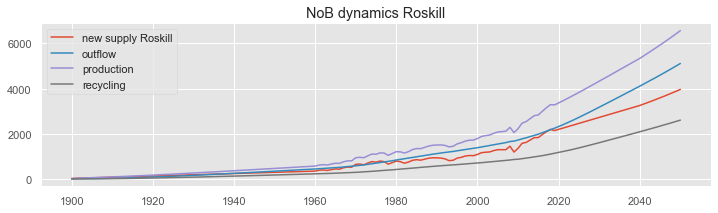

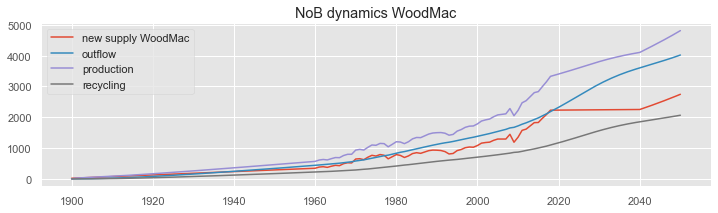

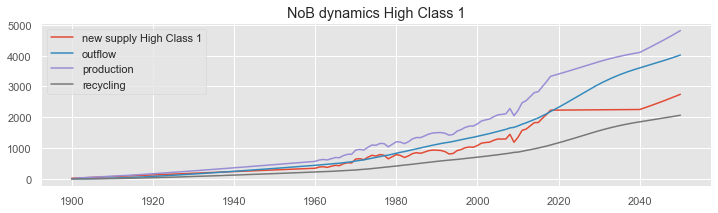

In [33]:
# Plot the results

# Inflows and Outflows

for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.figure(figsize=(12,3)) 
    plt.title('NoB dynamics {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[i,:], label='new supply {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_17_18'].Values[i,:],label='outflow'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_16_17'].Values[i,:], label='production'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_18_16'].Values[i,:], label='recycling'.format(n))
    plt.legend()



The outflows from this system are calculated using .18 as the proportion of ni outflows lost to carbon steel market (Reck 2007) and the remainder going to the Landfill

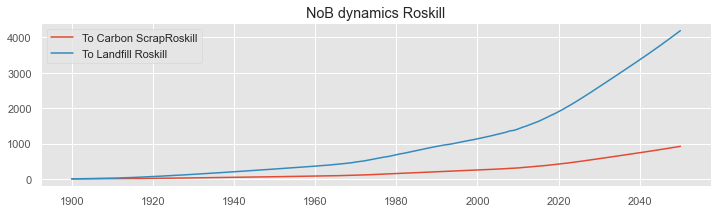

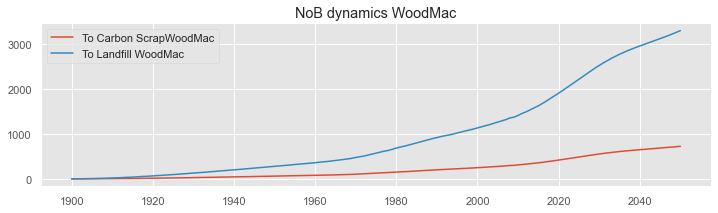

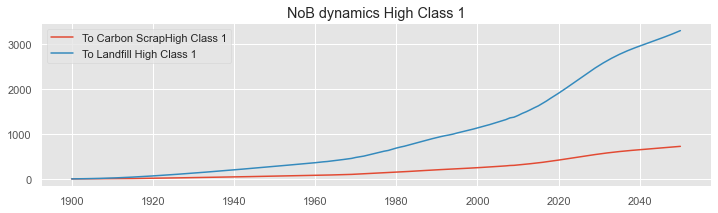

In [34]:
Ni_Supply_System.FlowDict['F_18_21'].Values = Ni_Supply_System.FlowDict['F_17_18'].Values * Carbon_Scrap_Losses
Ni_Supply_System.FlowDict['F_18_20'].Values = Ni_Supply_System.FlowDict['F_17_18'].Values - Ni_Supply_System.FlowDict['F_18_21'].Values
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.figure(figsize=(12,3)) 
    plt.title('NoB dynamics {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_18_21'].Values[i,:],label='To Carbon Scrap{}'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_18_20'].Values[i,:], label='To Landfill {}'.format(n))
    plt.legend()

### 4.4) Supply System

#### 4.4.1) Baseline supply characteristics

Now that the demand profiles are modeled, the supply characteristics will be added. In order to isolate the part of the supply system that would be affected by the parts of the system we are interested in, we will set baseline rates for the system aspects which we are not interested in adjusting. These rates are taken from literature sources. 

The primary effect of the NoB demand system in the model is to place a supply constraint on the available feedstocks to the LiB system. Therefore the baselines to this system will be set first.

The supply characteristics of Nickel to NoB system are somewhat flexible.
There are 4 possible products that can meet the supply
1- Ni Sulphate
2- Ni Metal
3- FeNi
4- NPI
However Ni Sulphate is only used in Electroplating and Class 2 products (FeNi and NPI) only used in Stainless Steel production. The Class 1 is flexible and has minimum demand levels in each First Use Segment

Ni Sulphate is only used in electroplating, - the value for this is taken from Roskill End Uses report. and growth in this will match the growth profile of Electroplating given by Wood Mac. It is the same in all scenarios but is indexed to NoB scenarios to reflect the understanding that it is driven by deman rather than supply.

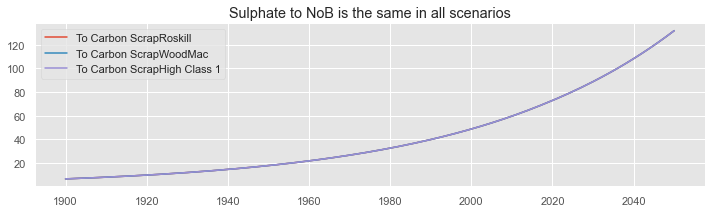

In [35]:
# NiSo4 to NoB
Ni_Supply_System.FlowDict['F_12_16'].Values = Ni_Supply_System.ParameterDict['Baseline_Sulphate_to_NoB'].Values
plt.figure(figsize=(12,3)) 
plt.title('Sulphate to NoB is the same in all scenarios')
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_12_16'].Values[i,:],label='To Carbon Scrap{}'.format(n))
    plt.legend()

Ni metal is used in all first uses, but there are minimum levels in the different sectors. Basically, for non-stainless sectors, the minimum is 100% (after Ni Sulphate use has been accounted for).
For Stainless first use sectors the demand for Ni Metal is low, but there is a minimum amount, as some pure ni is needed to tune the recipe for products. Due to the historic price premium of class 1 over class 2 products, this has already been pushed to a minimum. Muddying the waters further. Is the assertion in the Roskill report that recycling of scrap to stainless production can also reduce the need for class 1 to that sector. 

To account for this, the model will need a minimum amount of class 1 to NoB parameter. Which will be crudely calculated using the data from Roskill and WoodMac

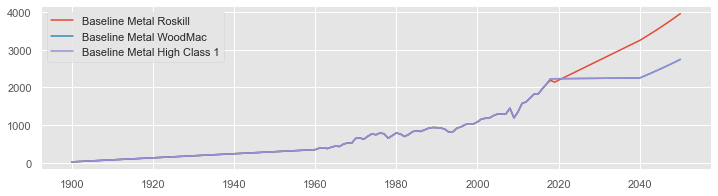

In [36]:
plt.figure(figsize=(12,3)) 

for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:],label='Baseline Metal {}'.format(nn))
plt.legend()


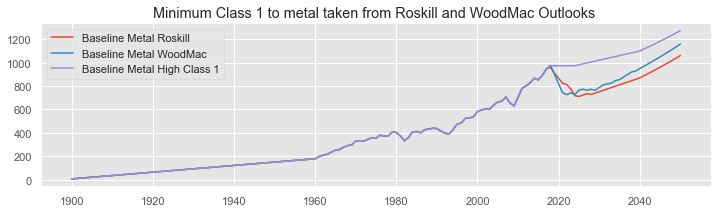

In [37]:
# minimum amount of Metal to NoB 

for N in range(NN):
    Ni_Supply_System.FlowDict['F_m11_16min'].Values[N,:] = Ni_Supply_System.ParameterDict['Baseline_Metal_Non_Stainless'].Values[N,:] + Ni_Supply_System.ParameterDict['Baseline_Metal_to_Stainless'].Values[N,:]

plt.figure(figsize=(12,3)) 
plt.title('Minimum Class 1 to metal taken from Roskill and WoodMac Outlooks ')

for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_m11_16min'].Values[N,:],label='Baseline Metal {}'.format(nn))
plt.legend()


The Baseline values of FeNi and NPI are historically taken as total production. So for historic years the demand to NoB is met by the baseline values with the remainder assumed to come from class 1 metal.
For future years this assumption switches to NPI as the feedstock to the remainder of NoB demand. 

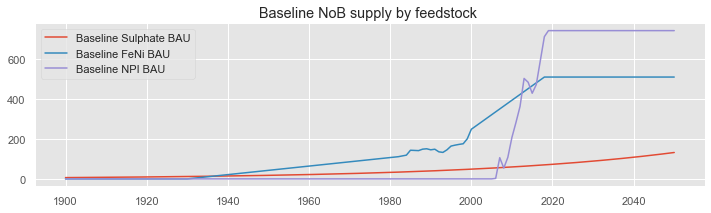

In [38]:
# FeNi to NoB is simply taken to be the baseline production for the entire model run
for S in range(NS):
    Ni_Supply_System.FlowDict['F_5_16'].Values = Ni_Supply_System.ParameterDict['FeNi_Production'].Values
    Ni_Supply_System.FlowDict['F_7_16'].Values[S,:,:,:,:] = Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:]
plt.figure(figsize=(12,3)) 
plt.title('Baseline NoB supply by feedstock ')
for S,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_12_16'].Values[S,:],label='Baseline Sulphate {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_5_16'].Values[S,:],label='Baseline FeNi {}'.format(n))
    plt.plot(model_run, Ni_Supply_System.FlowDict['F_7_16'].Values[S,0,0,0,:],label='Baseline NPI {}'.format(n))
    plt.legend()

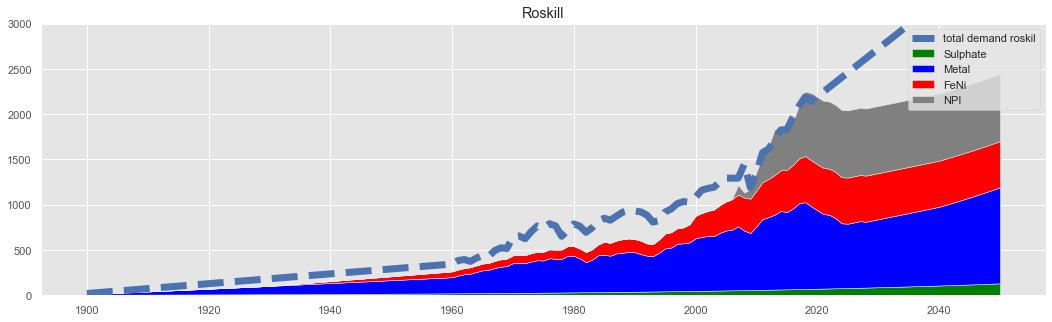

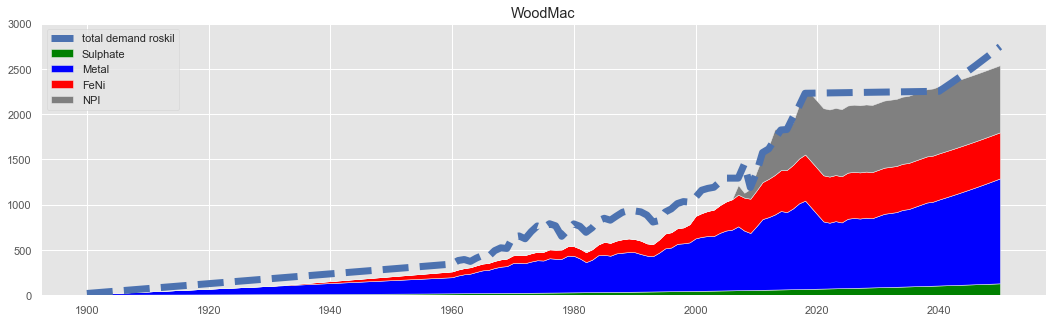

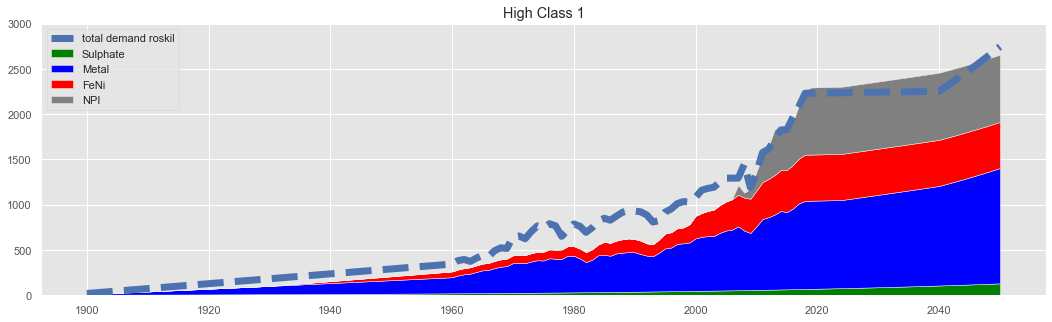

In [42]:
for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.figure(figsize=(18,5))
    plt.ylim(0,3000)
    plt.title('{}'.format(nn))
    plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:], linestyle='--', color='b', label='total demand roskil', linewidth='7')
    for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
        plt.stackplot(model_run, Ni_Supply_System.FlowDict['F_12_16'].Values[N,:],
                Ni_Supply_System.FlowDict['F_m11_16min'].Values[N,:],
                Ni_Supply_System.FlowDict['F_5_16'].Values[S,:],
                Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,0,0,:],
                 labels=['Sulphate'         ,'Metal'           ,'FeNi'          , 'NPI' ],
                 colors=['green'           ,'blue'                ,'red'        , 'grey'])
    plt.legend()


This method of assigning minimum baselines of different feedstocks to NoB production leaves a gap in the system of nickel demand which could be filled by various feedstocks.
For future years, this gap will be important to the model, in fact, the question mostly is how will this gap be filled?

For past years, this gap is not so important, the missing data is here filled by attributing additional Metal production to the value of the gap

In [ ]:
NoB_Gap1 = np.zeros((NS,NN,Nt))
for S in range(NS):
    for N in range(NN):
        for L in range(NL):
            for R in range (NR):
                NoB_Gap1[S,N,:] = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:]-\
            (Ni_Supply_System.FlowDict['F_12_16'].Values[N,:] +\
            Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:] +\
            Ni_Supply_System.FlowDict['F_5_16'].Values[S,:] +\
            Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:])

In [ ]:
plt.title('Remaining NoB Demand')
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:],label='demand gap {}{}'.format(sn,nn))
        plt.plot(model_run, (Ni_Supply_System.FlowDict['F_12_16'].Values[N,:] +\
            Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:] +\
            Ni_Supply_System.FlowDict['F_5_16'].Values[S,:] +\
            Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:] ),label='demand gap {}{}'.format(sn,nn))        
        plt.plot(model_run, NoB_Gap1[S,N,:],ls='--',label='demand gap {}{}'.format(sn,nn))
        plt.legend()

In [ ]:
plt.title('Metal to NoB')
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        plt.plot(model_run, Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:],label=' {}{}'.format(sn,nn))
        plt.legend()

In [ ]:
# Assign remainder of NoB demand to metal for historic years by subratcting FeNi and NPI from total demand
for S in range(NS):
    for N in range(NN):
        for L in range(NL):
            for R in range (NR):
        # before 2019, unmet nickel demand is satisfied by Metal production
                Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:119] = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:119] - (Ni_Supply_System.ParameterDict['FeNi_Production'].Values[S,:119]+ Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:119] + Ni_Supply_System.ParameterDict['Baseline_Sulphate_to_NoB'].Values[S,:119] )
        # After 2019, unmet nickel demand is satisfied by NPI
#                 Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,119:] = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,119] - (Ni_Supply_System.ParameterDict['FeNi_Production'].Values[S,119:]+Ni_Supply_System.ParameterDict['Baseline_Sulphate_to_NoB'].Values[S,119:] + Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,119:])        

In [ ]:
plt.title('Metal to NoB')
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        plt.plot(model_run, Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:],label=' {}{}'.format(sn,nn))
        plt.legend()

In [ ]:
# Recalculate gap 
NoB_Gap = np.zeros((NS,NN,Nt))
for S in range(NS):
    for N in range(NN):
        for L in range(NL):
            for R in range (NR):
                NoB_Gap[S,N,:] = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:] -\
            (Ni_Supply_System.FlowDict['F_12_16'].Values[N,:] +\
            Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:] +\
            Ni_Supply_System.FlowDict['F_5_16'].Values[S,:] +\
            Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:] )

In [ ]:
plt.title('Remaining NoB ')
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        plt.plot(model_run, NoB_Gap[S,N,:],label='demand gap {}{}'.format(sn,nn))
        plt.legend()

### This gap is going to need to be filled. How it gets filled will depend on the characteristics of the supply system and the LiB demand and recycling system

In [ ]:
for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    plt.figure(figsize=(18,5))
    plt.ylim(0,3000)
    plt.title('{}'.format(nn))
    plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:], linestyle='--', color='b', label='total demand roskil', linewidth='7')
    for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
        plt.stackplot(model_run, Ni_Supply_System.FlowDict['F_12_16'].Values[N,:],
                Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:],
                Ni_Supply_System.FlowDict['F_5_16'].Values[S,:],
                Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,0,0,:],
                 labels=['Sulphate'         ,'Metal'           ,'FeNi'          , 'NPI' ],
                 colors=['green'           ,'blue'                ,'red'        , 'grey'])
    plt.legend()


### The Ni sulphate supply is the central flow of the model. This heirarchy defines where PCAM demand is satisfied from
The suppy is met by a heirarchy of pathways:
1. Existing supply and stock
2. Recycling rate increase
3. Diversion of metal from NOB production (substituted with NPI) 
4. Sulphide to metal route growth
5. NPI to matte route increase


The baseline flows to the LiB system take place in the supply to process 12 - Sulphate Production. The supply of sulphate to Cathode production (flow 12-13) is given as meeting the LiB demand. As battery demand is recent and minor the baselines will not play a large role in the model, but they are important for making the recent years validate
Much of the Basline to Sulphate data is taken from Roskill's Nickel Sulphate Supply Data which was shared proprietarily (should not be published!)

In [ ]:
Image('Roskill Sulphate Data.png')

In [ ]:
# Cathode production equals cathodes to vehicle use
Ni_Supply_System.FlowDict['F_12_13'].Values = Ni_Supply_System.FlowDict['F_13_14'].Values
Ni_Supply_System.FlowDict['F_12_13'].Values.shape

A minimial amount of Sulphate is produced by way of Crude sulphate byproduct of cobals and copper production.  This amount is minimal and unlikely to increase. Values are taken from Roskill data and extrapolated historically. Future values are a 2% growth rate 

In [ ]:
# Total Crude Sulphate
Ni_Supply_System.FlowDict['F_19_12'].Values = Ni_Supply_System.ParameterDict['Crude_Sulphate_Production'].Values
plt.figure(figsize=(12,3))
plt.title('Crude Sulphate')
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.FlowDict['F_19_12'].Values[i,:],label='Baseline Sulphate {}'.format(n))
    plt.legend()

According to the working system definition, All new Leach-Intermediates are to be used in Sulphate Production. This is the justification for setting the baseline of Leach Intermediates to sulphate production, and having the remainder of sulphate production be sourced from metal.

The Leach-Intermediats to PCAM for historic years are taken from the roskill data above. and evenly extrapolated backward to 1994 which is assumed to be the first significant year of LiB production though this assumption has little significance for the study

For future years the Lint to PCAM will be a major scenario question. 
I will set the baselie to 2020 levels and set an additional parameter of 'new Lint capacity'

Roskill scenario will  be based on roskill predictions which show a levelling off at 2030 for unknown reasons


In [ ]:
  
# certain values are essentially outside the control of the ni supply system 
# such as recycling, LiB demand and NoB demand
# this is essentially mass balance of process 12

Upstream_PCAM_demand = np.zeros((NN,NL,NR,Nt)) # Demand that needs to be satisfied in the Supply system

for L in range(NL):
    for N in range(NN):
        for R in range(NR):   
            Upstream_PCAM_demand[N,L,R,:] = (Ni_Supply_System.FlowDict['F_12_13'].Values[L,:] +\
            Ni_Supply_System.FlowDict['F_12_16'].Values[N,:]) -\
            Ni_Supply_System.FlowDict['F_15_12'].Values[L,R,:] 


In [ ]:
flowString = "Supply System Demand to PCAM"
flowRA = Upstream_PCAM_demand    # flow array
plt.figure(figsize=(18,10))      
plt.title('{}'.format(flowString))
for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
    for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
        for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
            sns.lineplot(model_run,flowRA[N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
    plt.plot(model_run,Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,:] + Ni_Supply_System.ParameterDict['New_Lint_to_PCAM'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
    '''The heirarchy of pathways to supplying the feedstocks to PCAM'''
    # First attribute the amount of supply that can be attributed from Lint
    # Assignt the remainding demand to a variable called 'AfterLint'
AfterLint_PCAM_demand = np.zeros((NS,NN,NL,NR,Nt))
for S in range(NS):
        for L in range(NL):
            for N in range(NN):
                for R in range(NR):
                    for t in range(Nt):
        
        # if the demand is greater than the total Lint to PCAM, assign full Lint to PCAM values to flow and assign remainder of demand to after_Lint_PCAM_demand variable
                        if Upstream_PCAM_demand[N,L,R,t] - Ni_Supply_System.FlowDict['F_19_12'].Values[S,t] > Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,t] + Ni_Supply_System.ParameterDict['New_Lint_to_PCAM'].Values[S,t]:
                            Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,t] = Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,t] + Ni_Supply_System.ParameterDict['New_Lint_to_PCAM'].Values[S,t]
                            AfterLint_PCAM_demand[S,N,L,R,t] = Upstream_PCAM_demand[N,L,R,t] - (Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,t] + Ni_Supply_System.ParameterDict['New_Lint_to_PCAM'].Values[S,t])
        # if the demand is less than total Lint_to_PCAM, then flow 6_12 is total demand, and the rest of the Lint supply goes to metal
                        else:
                            Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,t] = Upstream_PCAM_demand[N,L,R,t] - Ni_Supply_System.FlowDict['F_19_12'].Values[S,t]
                            Ni_Supply_System.FlowDict['F_6_10additional'].Values[S,N,L,R,t] = (Ni_Supply_System.ParameterDict['Baseline_Lint_to_PCAM'].Values[S,t] + Ni_Supply_System.ParameterDict['New_Lint_to_PCAM'].Values[S,t]) - Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,t]
                            AfterLint_PCAM_demand[S,N,L,R,t] = 0
                            

In [ ]:
flowString = "Supply System Demand to PCAM"
flowRA = AfterLint_PCAM_demand    # flow array
plt.figure(figsize=(18,10))      
plt.title('Recycling {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,:] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

## At this point we have considered the amount of Lint that is being produced for PCAM consumption. Next the amount of Refinery capacity must be considered in order to determine the supply of Feedstocks to PCAM
for this we need the capacity of all Refineries. According to the list of facilities the total existing refining capacity is 1068, according to Roskill the total Class 1 production - and therefore the total output of all refineries, was 856
From discussions with experts, have I ascertained that no new Refineries have been produced in 20 years (leaving aside Vale Long Harbour), though some have closed. Therefore the decision has been made that existing refinery capacity will be set at 1000 and this is to include the 45 kt/year from Vale Long Harbour.

Following the system diagram, the amount of metal available to PCAM is the total metal capacity, less the amount of metal consumed in the NoB demand secor. 

In [ ]:
Ni_Supply_System.FlowDict['F_m11_16min'].Values.shape

In [ ]:
    '''The heirarchy of pathways to supplying the feedstocks to PCAM'''
    # Next attribute the amount of supply that can be attributed from Metal
    # Assignt the remainding demand to a variable called 'AfterMetal'
AfterMetal_PCAM_demand = np.zeros((NS,NN,NL,NR,Nt))
for S in range(NS):
        for L in range(NL):
            for N in range(NN):
                for R in range(NR):
                    for t in range(Nt):
        
        # if the AfterLint demand is greater than the total remaining metal capacity assign all remaining capacity to PCAM and assign remainder of demand to afterMetal  _PCAM_demand variable
                        if AfterLint_PCAM_demand[S,N,L,R,t] > Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,t]:
                            if Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,t] >= 0:
                                Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t] = Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,t]
                            else: 
                                Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t] = 0   
                            AfterMetal_PCAM_demand[S,N,L,R,t] = AfterLint_PCAM_demand[S,N,L,R,t] - Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t]
        # if the demand is less than total Metal capacity, then all the demand is satisfied by metal and the additional metal capacity goes to NoB system
                        else:
                            Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t] = AfterLint_PCAM_demand[S,N,L,R,t]
                            if t > 119:
                                Ni_Supply_System.FlowDict['F_m11_16additional'].Values[S,N,L,R,t] = Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,t] - Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t]
                            AfterMetal_PCAM_demand[S,N,L,R,t] = 0
                            

In [ ]:
flowString = "Supply System Demand to PCAM"
flowRA = Ni_Supply_System.FlowDict['F_m11_12'].Values    # flow array
plt.figure(figsize=(18,10))      
plt.title('Recycling {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
flowString = "Supply System Demand to PCAM"
flowRA = AfterMetal_PCAM_demand    # flow array
plt.figure(figsize=(18,10))      
plt.title('Recycling {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

## At this point, the only remaining consideration is the NPI, but it remains for both the NoB demand and the LiB demand. 
First the Nob demand is satisfied with the additional metal, and then the NPI flow is beefed up to accommodate it

In [ ]:
flowString = "Additional Metal to NoB"
flowRA = Ni_Supply_System.FlowDict['F_m11_16additional'].Values
# flow array
plt.figure(figsize=(18,10))      
plt.title('Recycling {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values.shape

In [ ]:
for S in range(NS):
        for L in range(NL):
            for N in range(NN):
                for R in range(NR):
                    for t in range(Nt):
                        Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,119:] = Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,119:] - Ni_Supply_System.ParameterDict['FeNi_Production'].Values[S,119:] - Ni_Supply_System.FlowDict['F_12_16'].Values[N,119:] - Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,119:] - Ni_Supply_System.FlowDict['F_m11_16additional'].Values[S,N,L,R,119:]        
                        

In [ ]:
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                plt.figure(figsize=(18,5))
#                 plt.ylim(0,3000)
                plt.title('{}{}{}{}'.format(sn,nn,ln,rn))
                plt.plot(model_run, Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:], linestyle='--', color='b', label='total demand', linewidth='7')
                plt.stackplot(model_run, Ni_Supply_System.FlowDict['F_12_16'].Values[N,:],
                        Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,:],
                        Ni_Supply_System.FlowDict['F_m11_16additional'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['F_5_16'].Values[S,:],
                        Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:],
                         labels=['Sulphate'         ,'Metal' ,'moremetal'          ,'FeNi'          , 'NPI' ],
                         colors=['green'           ,'blue'   ,'orange'             ,'red'        , 'grey'])
plt.legend()


In [ ]:
    '''The heirarchy of pathways to supplying the feedstocks to PCAM'''
    # Next attribute the amount of supply that can be attributed from Metal
    # Assignt the remainding demand to a variable called 'AfterMetal'

Unmet_PCAM_demand = np.zeros((NS,NN,NL,NR,Nt))
for S in range(NS):
        for L in range(NL):
            for N in range(NN):
                for R in range(NR):
                    for t in range(Nt):
        
        # if the AfterMetal_demand is greater than the total NPI capacity assign all remaining capacity to PCAM and assign remainder of demand to Unmet_PCAM_demand variable
                        if AfterMetal_PCAM_demand[S,N,L,R,t] > Ni_Supply_System.ParameterDict['NPI_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,t]:
                            Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,t] =  Ni_Supply_System.ParameterDict['NPI_Cap'].Values[S,t] - Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,t]
                            Unmet_PCAM_demand[S,N,L,R,t] = AfterMetal_PCAM_demand[S,N,L,R,t] - Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,t]
        # if the AfterMetal_demand is less than total NPI capacity, then all the demand is satisfied by NPI Capacity
                        else:
                            Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,t] = AfterMetal_PCAM_demand[S,N,L,R,t]
                            Unmet_PCAM_demand[S,N,L,R,t] = 0 # shouldn't be necessary to specify
                            

In [ ]:
Ni_Supply_System.FlowDict['F_7_12'].Values.shape

In [ ]:
flowString = "Supply System Demand to PCAM"
flowRA = Ni_Supply_System.FlowDict['F_7_12'].Values   # flow array
plt.figure(figsize=(18,10))      
plt.title('{}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['NPI_Production'].Values[S,:], linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
flowString = "After Lint Demand"
flowRA = AfterLint_PCAM_demand
plt.figure(figsize=(18,3))      
plt.title('Supply Scenarios {}'.format(flowString))
for S,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):      
    plt.plot(model_run,flowRA[S,0,0,0,:],label='Baseline lint {}'.format(n))
    plt.legend()
    
plt.figure(figsize=(18,3))      
plt.title('NoB Scenarios {}'.format(flowString))
for N,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,N,0,0,:],label='Baseline lint {}'.format(n))
    plt.legend()

    
plt.figure(figsize=(18,3))      
plt.title('LiB Scenarios {}'.format(flowString))
for L,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,0,L,0,:],label='Baseline lint {}'.format(n))
    plt.legend()

plt.figure(figsize=(18,3))      
plt.title('Recycling {}'.format(flowString))
for R,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,0,0,R,:],label='Baseline lint {}'.format(n))
    plt.legend()

In [ ]:
flowString = "Additional Demand"
flowRA = Ni_Supply_System.FlowDict['F_7_12'].Values   # flow array
plt.figure(figsize=(18,3))      
plt.title('Supply Scenarios {}'.format(flowString))
for S,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):      
    plt.plot(model_run,flowRA[S,0,0,0,:],label='Baseline lint {}'.format(n))
    plt.legend()
    
plt.figure(figsize=(18,3))      
plt.title('NoB Scenarios {}'.format(flowString))
for N,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,N,0,0,:],label='Baseline lint {}'.format(n))
    plt.legend()
    
plt.figure(figsize=(18,3))      
plt.title('LiB Scenarios {}'.format(flowString))
for L,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,0,L,0,:],label='Baseline lint {}'.format(n))
    plt.legend()

plt.figure(figsize=(18,3))      
plt.title('Recycling {}'.format(flowString))
for R,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
    plt.plot(model_run,flowRA[0,0,0,R,:],label='Baseline lint {}'.format(n))
    plt.legend()

In [ ]:
# Sulphide concentrate to DC refining given by parameter
Ni_Supply_System.FlowDict['F_3_m11'].Values = Ni_Supply_System.ParameterDict['DC_Refinery_Production'].Values

plt.figure(figsize=(12,3))
plt.title('DCR')
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.FlowDict['F_3_m11'].Values[i,:],label='Baseline Sulphate {}'.format(n))
    plt.legend()

In [ ]:
'''Ferronickel is set by parameters and essentially independent from LIB activity'''
# Matte from Red Roast from parameter
Ni_Supply_System.FlowDict['F_8a_m9'].Values = Ni_Supply_System.ParameterDict['Red_Roast_Production'].Values
# Reduction Roasting Losses
Ni_Supply_System.FlowDict['F_8a_0'].Values = Ni_Supply_System.FlowDict['F_8a_m9'].Values * Reduction_Roasting_Losses

# FeNi to roast 
Ni_Supply_System.FlowDict['F_5_8a'].Values = (Ni_Supply_System.FlowDict['F_8a_m9'].Values +\
    Ni_Supply_System.FlowDict['F_8a_0'].Values) 
plt.figure(figsize=(12,3))
plt.title('Reduction Roasting')
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.FlowDict['F_5_8a'].Values[i,:],label='{}'.format(n))
    plt.legend()

In [ ]:
# FeNi to NOB production is FeNi prod parameter less FeNi to Reduction Roast
for S in range(NS):
    for t in range(Nt):
        Ni_Supply_System.FlowDict['F_2_5'].Values[S,t] = (Ni_Supply_System.FlowDict['F_5_16'].Values[S,t] +\
    Ni_Supply_System.FlowDict['F_5_8a'].Values[S,t] ) * (1+FeNi_Smelting_Losses) 

plt.figure(figsize=(12,3))
plt.title('FeNi')
for i,n in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.FlowDict['F_2_5'].Values[i,:],label='{}'.format(n))
    plt.legend()


In [ ]:
                         Ni_Supply_System.FlowDict['F_m11_16min'].Values.shape

In [ ]:
# Ni Matte production is mass balance from Refinery
# to calculate this we first need to calculate the amount of metal being produced by DCRefining
for S in range(NS):
        for L in range(NL):
            for N in range(NN):
                for R in range(NR):
                    for t in range(Nt):
                        Ni_Supply_System.FlowDict['F_10_m11'].Values[S,N,L,R,t] =\
                        (Ni_Supply_System.FlowDict['F_m11_12'].Values[S,N,L,R,t] +\
                         Ni_Supply_System.FlowDict['F_m11_16min'].Values[S,N,t] +\
                         Ni_Supply_System.FlowDict['F_m11_16additional'].Values[S,N,L,R,t]) -\
                                               Ni_Supply_System.FlowDict['F_3_m11'].Values[S,t]
flowString = "production from Refining"
flowRA = Ni_Supply_System.FlowDict['F_10_m11']   # flow array
plt.figure(figsize=(18,10))      
plt.title('Recycling {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA.Values[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['Metal_Refining_Cap'].Values[S,:]-\
             Ni_Supply_System.FlowDict['F_3_m11'].Values[S,:] , linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
Ni_Supply_System.FlowDict['F_6_10additional'].Values.shape


In [ ]:
for S in range(NS):
    for L in range(NL):
        for N in range(NN):
            for R in range(NR):
#                 for t in range(Nt):
                Ni_Supply_System.FlowDict['F_m9_10'].Values[S,N,L,R,:]=\
                    (Ni_Supply_System.FlowDict['F_10_m11'].Values[S,N,L,R,:] *\
                    (1+ Metal_Refining_Losses))-\
                    (Ni_Supply_System.FlowDict['F_6_10original'].Values[S,:] +\
                     Ni_Supply_System.FlowDict['F_6_10original'].Values[S,:])

# and Mass balance of Matte Market (no losses in the market)
                Ni_Supply_System.FlowDict['F_4_m9'].Values[S,N,L,R,:]=\
                    Ni_Supply_System.FlowDict['F_m9_10'].Values[S,N,L,R,:] -\
                    Ni_Supply_System.FlowDict['F_8a_m9'].Values[S,:]
    
flowString = "Matte Production"
flowRA1 = Ni_Supply_System.FlowDict['F_m9_10']   # flow array
flowRA2 = Ni_Supply_System.FlowDict['F_4_m9']   # flow array
plt.figure(figsize=(18,10))      
plt.title(' {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA1.Values[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))
                sns.lineplot(model_run,flowRA2.Values[S,N,L,R,:],label=' {}{}{}'.format(nn,ln,rn))

for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    plt.plot(model_run,Ni_Supply_System.ParameterDict['Matte_Smelting_Cap'].Values[S,:] , linestyle="--",label='Baseline lint {}'.format(sn))
plt.legend(loc=2)

In [ ]:
'''Ore production driven by downstream consumption'''
# Sulphide Ore to Smelting
Ni_Supply_System.FlowDict['F_1_4'].Values = Ni_Supply_System.FlowDict['F_4_m9'].Values *\
                                             (1+Matte_Smelting_Losses)
# Sulphide Ore to DCR
Ni_Supply_System.FlowDict['F_1_3'].Values = Ni_Supply_System.FlowDict['F_3_m11'].Values *\
                                             (1+Direct_Concentrate_Refining_Losses)
#Saprolite to FeNi production is FeNi prod plus losses
Ni_Supply_System.FlowDict['F_2_5'].Values = Ni_Supply_System.FlowDict['F_5_8a'].Values + Ni_Supply_System.FlowDict['F_5_16'].Values *\
                                             (1+FeNi_Smelting_Losses)

In [ ]:
#Li to LINT
Ni_Supply_System.FlowDict['F_2_6'].Values = (Ni_Supply_System.FlowDict['F_6_12'].Values +\
                                             Ni_Supply_System.FlowDict['F_6_10original'].Values +\
                                             Ni_Supply_System.FlowDict['F_6_10additional'].Values)*\
                                             (1+Laterite_Leaching_Losses)

In [ ]:
# Limonite to NPI = NOB demand + production losses
Ni_Supply_System.FlowDict['F_2_7'].Values = (Ni_Supply_System.FlowDict['F_7_16'].Values + \
    Ni_Supply_System.FlowDict['F_7_12'].Values) * (1+ NPI_Smelting_Losses)

plt.figure(figsize=(12,3))        
plt.plot(model_run, Ni_Supply_System.FlowDict['F_1_3'].Values[0,:], color='purple', label='Sulphide to DCR')
plt.plot(model_run, Ni_Supply_System.FlowDict['F_1_4'].Values[0,0,0,0,:], color='purple', label='Sulphide to Matte')
plt.plot(model_run, Ni_Supply_System.FlowDict['F_2_6'].Values[0,0,0,0,:], color='yellow', label='Limonite to LINT')
plt.plot(model_run, Ni_Supply_System.FlowDict['F_2_5'].Values[0,:], color='orange', label='Saprolite-FeNi')
plt.plot(model_run, Ni_Supply_System.FlowDict['F_2_7'].Values[0,0,0,0,:], color='red', label='Limonite to NPI')
plt.legend()

In [ ]:
Ni_Supply_System.FlowDict['F_1_3'].Values.shape

In [ ]:
'''reserve consumption'''
Ni_Supply_System.FlowDict['F_0_1'].Values = (Ni_Supply_System.FlowDict['F_1_3'].Values + Ni_Supply_System.FlowDict['F_1_4'].Values) * (1+Sulphide_Mining_Losses)
Ni_Supply_System.FlowDict['F_0_2'].Values = (Ni_Supply_System.FlowDict['F_2_6'].Values + Ni_Supply_System.FlowDict['F_2_5'].Values + Ni_Supply_System.FlowDict['F_2_7'].Values) * (1+Laterite_Mining_Losses)

flowString = "Matte Production"
flowRA1 = Ni_Supply_System.FlowDict['F_0_1']   # flow array
flowRA2 = Ni_Supply_System.FlowDict['F_0_2']   # flow array
plt.figure(figsize=(18,10))      
plt.title(' {}'.format(flowString))
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,rn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):      
                sns.lineplot(model_run,flowRA1.Values[S,N,L,R,:],color='r',label=' {}{}{}'.format(nn,ln,rn))
                sns.lineplot(model_run,flowRA2.Values[S,N,L,R,:],color='b',label=' {}{}{}'.format(nn,ln,rn))
                plt.plot(model_run,Ni_Supply_System.ParameterDict['NoB_Ni_Demand'].Values[N,:], color='black', linestyle="--",label='demand {}'.format(sn))
                plt.plot(model_run,Ni_Supply_System.ParameterDict['LiB_Ni_Demand'].Values[L,:], color='black', linestyle="--",label='demand {}'.format(sn))
plt.legend(loc=2)

In [ ]:
# '''Process activity'''

# for S in range(NS):
#     for L in range(NL):
#         for N in range(NN):
#             for R in range(NR):
# #                 for t in range(Nt):
#                 PRO_1[S,N,L,R,:]=(Ni_Supply_System.FlowDict['F_1_3'].Values[S,:] + Ni_Supply_System.FlowDict['F_1_4'].Values[S,N,L,R,:])
#                 PRO_2=(Ni_Supply_System.FlowDict['F_2_5'].Values[S,:] + Ni_Supply_System.FlowDict['F_2_6'].Values[S,N,L,R,:] + Ni_Supply_System.FlowDict['F_2_7'].Values[S,N,L,R,:])
#                 PRO_3=(Ni_Supply_System.FlowDict['F_3_m11'].Values[S,:])
#                 PRO_4=Ni_Supply_System.FlowDict['F_4_m9'].Values[S,N,L,R,:]
#                 PRO_5=Ni_Supply_System.FlowDict['F_5_8a'].Values[S,:] + Ni_Supply_System.FlowDict['F_5_16'].Values[S,:]
#                 PRO_6=Ni_Supply_System.FlowDict['F_6_10original'].Values[S,:] + Ni_Supply_System.FlowDict['F_6_10additional'].Values[S,N,L,R,:] + Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,:]
#                 PRO_7=Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,:] + Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:]
#                 PRO_8a=Ni_Supply_System.FlowDict['F_8a_m9'].Values[S,:]
#                 PRO_8a=Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,:]
#                 PRO_10=Ni_Supply_System.FlowDict['F_10_m11'].Values[S,N,L,R,:]
#                 PRO_12=Ni_Supply_System.FlowDict['F_12_13'].Values[L,:] + Ni_Supply_System.FlowDict['F_12_16'].Values[N,:]

## 5) Mass-balance-check
One major advantage of the ODYM system structure is that mass balance checks can be performed automatically using unit-tested routines without further programming need:

In [ ]:
# Bal = Ni_Supply_System.MassBalance()
# print(Bal.shape) # dimensions of balance are: time step x process x chemical element
# print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

The ODYM mass balance array reports the balance for each chemical element, each year, and each process, including the system balance (process 0).

The result shows that both the system processes and the system as a whole are balanced.

## 6) Emissions calculations
In the given system there are 9 pathways to making first use nickel products $\textbf{Before Sulphate Production}$.
The layout of the system is that single flows can be representative of total production along various patheways.  In this way, the supply system can be visualized via a stackplot of these 9 flows. plus the sulphate production on a separate axis 

In [ ]:
'''Initializing representative pathways'''
Ni_Supply_System.FlowDict['Path1'] = msc.Flow(Name = 'Byproducts', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path2'] = msc.Flow(Name = 'Direct Concentrate Refining', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path3'] = msc.Flow(Name = 'Sulphide Matte Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path4'] = msc.Flow(Name = 'FeNi Sulphidization to Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path5'] = msc.Flow(Name = 'FeNi to NoB', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path6'] = msc.Flow(Name = 'HPAL to Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path7'] = msc.Flow(Name = 'HPAL to Sulphate Precurser', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path8'] = msc.Flow(Name = 'NPI to NoB', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)
Ni_Supply_System.FlowDict['Path9'] = msc.Flow(Name = 'NPI to Sulphate Precurser', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)

Ni_Supply_System.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.


In [ ]:
Ni_Supply_System.FlowDict['F_3_m11'].Values.shape

In [ ]:

# make a stackplot of all 
for S in range(NS):
    for L in range(NL):
        for N in range(NN):
            for R in range(NR):                
                Ni_Supply_System.FlowDict['Path1'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_19_12'].Values[S,:]
                Ni_Supply_System.FlowDict['Path2'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_3_m11'].Values[S,:]
                Ni_Supply_System.FlowDict['Path3'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_4_m9'].Values[S,N,L,R,:]*(1-Metal_Refining_Losses)
                Ni_Supply_System.FlowDict['Path4'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_8a_m9'].Values[S,:]*(1-Metal_Refining_Losses)
                Ni_Supply_System.FlowDict['Path5'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_5_16'].Values[S,:]
                Ni_Supply_System.FlowDict['Path6'].Values[S,N,L,R,:] =        (Ni_Supply_System.FlowDict['F_6_10original'].Values[S,:] + Ni_Supply_System.FlowDict['F_6_10additional'].Values[S,N,L,R,:]) *(1-Metal_Refining_Losses)
                Ni_Supply_System.FlowDict['Path7'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,:]
                Ni_Supply_System.FlowDict['Path8'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:]
                Ni_Supply_System.FlowDict['Path9'].Values[S,N,L,R,:] =        Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,:]

In [ ]:
# make a stackplot of all 
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,nrn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):
                plt.figure(figsize=(18,8))
                plt.title('All Pathways {} {} {} {}'.format(sn,nn,ln,rn))
                plt.xlim(1990,2050)     
                plt.plot(model_run, Ni_Supply_System.FlowDict['F_12_13'].Values[L,:] + Ni_Supply_System.FlowDict['F_12_16'].Values[N,:], linestyle='--', color='lime', label='Sulphate Production', linewidth='7')
                plt.stackplot(model_run, 
                        Ni_Supply_System.FlowDict['F_19_12'].Values[S,:],
                        Ni_Supply_System.FlowDict['F_3_m11'].Values[S,:],
                        Ni_Supply_System.FlowDict['F_4_m9'].Values[S,N,L,R,:]*(1-Metal_Refining_Losses),
                        Ni_Supply_System.FlowDict['F_8a_m9'].Values[S,:]*(1-Metal_Refining_Losses),
                        Ni_Supply_System.FlowDict['F_5_16'].Values[S,:],
                        (Ni_Supply_System.FlowDict['F_6_10original'].Values[S,:] + Ni_Supply_System.FlowDict['F_6_10additional'].Values[S,N,L,R,:]) *(1-Metal_Refining_Losses),
                        Ni_Supply_System.FlowDict['F_6_12'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['F_7_16'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['F_7_12'].Values[S,N,L,R,:],
                         labels=['Byproduct' , 'DCR'      , 'Sulphide Matte','FeNi Sulphidization','FeNi NoB','HPAL to Metal','HPAL to Sulphate', 'NPI NoB', 'NPI Sulphidization'],
                         colors=['darkgreen', 'navy', 'blue'          ,'purple'             ,'red'     , 'cyan'        ,'yellow'           , 'grey'  , 'black' ])
                plt.legend(loc=2)


In [ ]:
GHG_Path1 = 5
GHG_Path2 = 9
GHG_Path3 = 24
GHG_Path4 = 45
GHG_Path5 = 41
GHG_Path6 = 26
GHG_Path7 = 24
GHG_Path8 = 45
GHG_Path9 = 50

In [ ]:
'''Initializing representative GHGways'''
Ni_Supply_System.FlowDict['GHG1'] = msc.Flow(Name = 'Byproducts', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path1'].Values*GHG_Path1)
Ni_Supply_System.FlowDict['GHG2'] = msc.Flow(Name = 'Direct Concentrate Refining', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path2'].Values*GHG_Path1)
Ni_Supply_System.FlowDict['GHG3'] = msc.Flow(Name = 'Sulphide Matte Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path3'].Values*GHG_Path3)
Ni_Supply_System.FlowDict['GHG4'] = msc.Flow(Name = 'FeNi Sulphidization to Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path4'].Values*GHG_Path4)
Ni_Supply_System.FlowDict['GHG5'] = msc.Flow(Name = 'FeNi to NoB', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path5'].Values*GHG_Path5)
Ni_Supply_System.FlowDict['GHG6'] = msc.Flow(Name = 'HPAL to Metal', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path6'].Values*GHG_Path6)
Ni_Supply_System.FlowDict['GHG7'] = msc.Flow(Name = 'HPAL to Sulphate Precurser', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path7'].Values*GHG_Path7)
Ni_Supply_System.FlowDict['GHG8'] = msc.Flow(Name = 'NPI to NoB', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path8'].Values*GHG_Path8)
Ni_Supply_System.FlowDict['GHG9'] = msc.Flow(Name = 'NPI to Sulphate Precurser', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=Ni_Supply_System.FlowDict['Path9'].Values*GHG_Path9)
Ni_Supply_System.FlowDict['GHG_ALL'] = msc.Flow(Name = 'NPI to Sulphate Precurser', P_Start = 0, P_End = 12,
                                            Indices = 'S,N,L,R,t', Values=None)

Ni_Supply_System.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.


In [ ]:
Ni_Supply_System.FlowDict['GHG9'].Values.sum()

In [ ]:
# make a stackplot of all 
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,nrn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):
                Ni_Supply_System.FlowDict['GHG_ALL'].Values[S,N,L,R,:] =\
                        Ni_Supply_System.FlowDict['GHG1'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG2'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG3'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG4'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG5'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG6'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG7'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG8'].Values[S,N,L,R,:]+\
                        Ni_Supply_System.FlowDict['GHG9'].Values[S,N,L,R,:]
 

In [ ]:
# make a stackplot of all 
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,nrn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):
                plt.figure(figsize=(18,8))
                plt.title('All Pathways {} {} {} {}'.format(sn,nn,ln,rn))
                plt.xlim(1990,2050)     
                plt.plot(model_run, Ni_Supply_System.FlowDict['GHG_ALL'].Values[S,N,L,R,:] + Ni_Supply_System.FlowDict['F_12_16'].Values[N,:], linestyle='--', color='lime', label='Sulphate Production', linewidth='7')
                plt.stackplot(model_run, 
                        Ni_Supply_System.FlowDict['GHG1'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG2'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG3'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG4'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG5'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG6'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG7'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG8'].Values[S,N,L,R,:],
                        Ni_Supply_System.FlowDict['GHG9'].Values[S,N,L,R,:],
                         labels=['Byproduct' , 'DCR'      , 'Sulphide Matte','FeNi Sulphidization','FeNi NoB','HPAL to Metal','HPAL to Sulphate', 'NPI NoB', 'NPI Sulphidization'],
                         colors=['darkgreen', 'navy', 'blue'          ,'purple'             ,'red'     , 'cyan'        ,'yellow'           , 'grey'  , 'black' ])
                plt.legend(loc=2)


In [ ]:
TOTALGHG =[]
for S in range(NS):
    for L in range(NL):
        for N in range(NN):
            for R in range(NR):                
                TOTALGHG.append(Ni_Supply_System.FlowDict['GHG_ALL'].Values[S,N,L,R,120:].sum())
TOTALGHG

In [ ]:
# make a lineplot of all 
plt.figure(figsize=(18,8))
plt.title('All Pathways GHG')
plt.xlim(1990,2050)     
for S,sn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Supply_Scenario')].Items):
    for N,nn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('NoB_Scenario')].Items):
        for L,ln in enumerate(IndexTable.Classification[IndexTable.index.get_loc('LiB_Scenario')].Items):
            for R,nrn in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Rec_Scenario')].Items):
                plt.plot(model_run, Ni_Supply_System.FlowDict['GHG_ALL'].Values[S,N,L,R,:], label='Total GHG')

In [ ]:
sns.barplot(list(range(len(TOTALGHG))),TOTALGHG)

## Start by making a Dataframe of the flows

In [ ]:
# For each scenario make a different DF?
# for s in range(Ns)
index = Ni_Supply_System.IndexTable['Classification']['Time'].Items
Flow_df = pd.DataFrame(np.einsum('sret->t',Ni_Supply_System.FlowDict['F_1_3'].Values),index=index, columns = ['F_1_3_t'])
Flow_df['F_1_4_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_1_4'].Values)
Flow_df['F_2_5_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_2_5'].Values)
Flow_df['F_2_6_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_2_6'].Values)
Flow_df['F_2_7_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_2_7'].Values)
Flow_df['F_3_m11_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_3_m11'].Values)
Flow_df['F_4_m9_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_4_m9'].Values)
Flow_df['F_5_8_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_5_8'].Values)
Flow_df['F_5_15_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_5_15'].Values)
Flow_df['F_6_10_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_6_10'].Values)
Flow_df['F_6_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_6_12'].Values)
Flow_df['F_7_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_7_12'].Values)
Flow_df['F_7_15_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_7_15'].Values)
Flow_df['F_8_m9_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_8_m9'].Values)
Flow_df['F_m9_10_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_m9_10'].Values)
Flow_df['F_10_m11_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_10_m11'].Values)
Flow_df['F_m11_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_m11_12'].Values)
Flow_df['F_m11_15_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_m11_15'].Values)
Flow_df['F_12_13_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_12_13'].Values)
Flow_df['F_12_15_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_12_15'].Values)
Flow_df['F_13_14_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_13_14'].Values)
Flow_df['F_14_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_14_12'].Values)
Flow_df['F_14_19_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_14_19'].Values)
Flow_df['F_15_16_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_15_16'].Values)
Flow_df['F_16_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_16_12'].Values)
Flow_df['F_16_15_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_16_15'].Values)
Flow_df['F_16_18_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_16_18'].Values)
Flow_df['F_16_19_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_16_19'].Values)
Flow_df['F_17_12_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_17_12'].Values)
Flow_df['F_0_1_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_0_1'].Values)
Flow_df['F_0_2_t'] = np.einsum('sret->t',Ni_Supply_System.FlowDict['F_0_2'].Values)
Flow_df['PRO_1_t'] = np.einsum('sret->t',PRO_1)
Flow_df['PRO_2_t'] = np.einsum('sret->t',PRO_2)
Flow_df['PRO_3_t'] = np.einsum('sret->t',PRO_3)
Flow_df['PRO_4_t'] = np.einsum('sret->t',PRO_4)
Flow_df['PRO_5_t'] = np.einsum('sret->t',PRO_5)
Flow_df['PRO_6_t'] = np.einsum('sret->t',PRO_6)
Flow_df['PRO_7_t'] = np.einsum('sret->t',PRO_7)
Flow_df['PRO_8_t'] = np.einsum('sret->t',PRO_8)
Flow_df['PRO_10_t'] = np.einsum('sret->t',PRO_10)
Flow_df['PRO_12_t'] = np.einsum('sret->t',PRO_12)

Flow_df

In [ ]:
df.index


In [ ]:
'''Plot of all flows in data frame'''
# # create a color palette
# palette = plt.get_cmap('Set1')

# # multiple line plot
# num=0
# for column in Flow_df:
#     if Flow_df[column].sum()!=0:
#         num+=1

#         # Find the right spot on the plot
#         plt.figure(figsize=(10,100))
#         plt.subplot(len(Flow_df.columns),1, num)


#         # Plot the lineplot
#         plt.plot(model_run, Flow_df[column], marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=column)


#         # Add title
#         plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )


In [ ]:
title_string=('LIB Demand')
plt.figure(figsize=(18,10))
plt.stackplot(model_run, Flow_df['F_14_12_t'], Flow_df['F_17_12_t'], Flow_df['F_16_12_t'], Flow_df['F_m11_12_t'], Flow_df['F_6_12_t'],
                 labels=[ 'LIB Recycling', 'Crude Slphate', 'NOB Recycling', 'Metal', 'Leach Intermediates'],
                 colors=['green'        ,  'c'            , 'grey'         , 'blue' , 'yellow'])
plt.plot(Flow_df['F_12_13_t'], linestyle='--', color='r', label='LIB Demand', linewidth=4)
plt.xlim(left=1980)
plt.ylabel('kT Ni in Product')
plt.legend(loc = 'upper left')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

In [ ]:
title_string=('LIB demand NO Recycling')
plt.figure(figsize=(18,10))

plt.stackplot(model_run, Flow_df['F_17_12_t'], Flow_df['F_16_12_t'], Flow_df['F_m11_12_t'], Flow_df['F_6_12_t'],
                 labels=[ 'Crude Slphate', 'NOB Recycling', 'Metal', 'Leach Intermediates'],
                 colors=[  'c'            , 'grey'         , 'blue' , 'yellow'])
plt.plot(Flow_df['F_12_13_t']- Flow_df['F_14_12_t'], linestyle='--', color='r', label='LIB demand', linewidth=4)
plt.xlim(left=1980)
plt.legend(loc = 'upper left')
plt.ylabel('kT Ni in Product')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

In [ ]:
demand_df.iloc[:,1]

In [ ]:
title_string=('Total System Demand of Intermediate Products & Recycling')
plt.figure(figsize=(18,10))
plt.stackplot(model_run, Flow_df['F_7_15_t'], Flow_df['F_5_15_t'] , Flow_df['F_m11_15_t'], Flow_df['F_16_15_t'],Flow_df['F_14_12_t'], Flow_df['F_17_12_t'], Flow_df['F_16_12_t'], Flow_df['F_m11_12_t'], Flow_df['F_6_12_t'],
                 labels=['NPI-NOB'          ,'FeNi-NOB'           ,'Metal-NOB'          , 'NOB-NOB Recycling' , 'LIB-LIB Recycling' , 'Crude Slphate'     , 'NOB-LIB Recycle'  , 'Metal'              , 'Leach Intermediates'],
                 colors=['orange'           ,'red'                ,'blue'               ,  'grey'             , 'green'             , 'cyan'              , 'grey'             , 'blue'               , 'yellow'])
plt.plot(Flow_df['F_15_16_t']+Flow_df['F_12_13_t'], linestyle='-.', color='r', label='System Demand', linewidth='4')
plt.xlim(left=1980)
plt.legend(loc = 'upper left')
plt.ylabel('kT Ni in Product')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

In [ ]:
title_string='Total System Demand of Intermediate Products NO Recycling'
plt.figure(figsize=(18,10))
plt.stackplot(model_run, Flow_df['F_7_15_t'], Flow_df['F_5_15_t'] , Flow_df['F_m11_15_t'], Flow_df['F_17_12_t'], Flow_df['F_m11_12_t'], Flow_df['F_6_12_t'],
                 labels=['NPI-NOB'          ,'FeNi-NOB'           ,'Metal-NOB'          , 'Crude Slphate'     ,  'Metal-LIB'          , 'Leach Intermediates'],
                 colors=['orange'           ,'red'                ,'blue'               , 'cyan'              , 'blue'               , 'yellow'])
plt.plot(Flow_df['F_15_16_t']+Flow_df['F_12_13_t'], linestyle='-.', color='r', label='System Demand', linewidth='4')
plt.xlim(left=1950)
plt.legend(loc = 'upper left')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.xlabel('Year')
plt.ylabel('kT Ni in Product')
plt.show()

In [ ]:
title_string='Total System Demand of Intermediate Products NO Recycling (recycling excluded from demand)'
plt.figure(figsize=(18,10))
plt.stackplot(model_run, Flow_df['F_7_15_t'], Flow_df['F_5_15_t'] , Flow_df['F_m11_15_t'], Flow_df['F_17_12_t'], Flow_df['F_m11_12_t'], Flow_df['F_6_12_t'],
                 labels=['NPI-NOB'          ,'FeNi-NOB'           ,'Metal-NOB'          , 'Crude Slphate'     ,  'Metal-LIB'          , 'Leach Intermediates'],
                 colors=['orange'           ,'red'                ,'blue'               , 'cyan'              , 'blue'               , 'yellow'])
plt.plot(Flow_df['F_15_16_t']+Flow_df['F_12_13_t']-Flow_df['F_16_15_t']-Flow_df['F_14_12_t']- Flow_df['F_16_12_t'], linestyle='-.', color='r', label='System Demand', linewidth='4')
# plt.xlim(left=1980)
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('kT Ni in Product')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

In [ ]:
title_string=('Production per Processes')
plt.figure(figsize=(18,10))
plt.stackplot(model_run, Flow_df['PRO_1_t'], 
              Flow_df['PRO_2_t'], Flow_df['PRO_3_t'], Flow_df['PRO_4_t'], 
              Flow_df['PRO_5_t'], Flow_df['PRO_6_t'], Flow_df['PRO_7_t'],
              Flow_df['PRO_8_t'], Flow_df['PRO_10_t'], Flow_df['PRO_12_t'],
              labels=['SULPHIDE MINING', 'LATERITE MINING', 'DC REFINING', 'MATTE SMELTING', 'FENI SMELTING', 'LATERITE LEACHING', 'NPI SMELTING', 'METAL REFINING', 'PCAM PRODUCTION'])
# plt.plot(Flow_df['F_15_16_t']+Flow_df['F_12_13_t'])
# plt.xlim(left=1980)
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('kT Ni Produced per Year')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

## Diagrams for presentation

In [ ]:
#diagram fonts
titlefont = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 32,}
axisfont ={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 32,}

legendfont={'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 22,}


In [ ]:
Production_2019= Flow_df['F_7_15_t'][2019] + Flow_df['F_5_15_t'][2019] + Flow_df['F_m11_15_t'][2019] + Flow_df['F_16_15_t'][2019] +Flow_df['F_14_12_t'][2019] + Flow_df['F_17_12_t'][2019] + Flow_df['F_16_12_t'][2019] + Flow_df['F_m11_12_t'][2019] + Flow_df['F_6_12_t'][2019]
Production_2019

In [ ]:
post_scrap_demand = Ni_Supply_System.ParameterDict['NOB_Demand_Post_Scrap'].Values[0,0,0,:]
post_scrap_demand

In [ ]:
'''gap and capacity'''
title_string=('Total System Demand of Intermediate Products & Recycling')
plt.figure(figsize=(18,10))
plt.stackplot(model_run[80:120], Flow_df['F_7_15_t'][1980:2019], Flow_df['F_5_15_t'][1980:2019] , Flow_df['F_m11_15_t'][1980:2019], Flow_df['F_16_15_t'][1980:2019],Flow_df['F_14_12_t'][1980:2019], Flow_df['F_17_12_t'][1980:2019], Flow_df['F_16_12_t'][1980:2019], Flow_df['F_m11_12_t'][1980:2019], Flow_df['F_6_12_t'][1980:2019],
                 labels=['NPI-NOB'          ,'FeNi-NOB'           ,'Metal-NOB'          , 'NOB-NOB Recycling' , 'LIB-LIB Recycling' , 'Crude Slphate'     , 'NOB-LIB Recycle'  , 'Metal'              , 'Leach Intermediates'],
                 colors=['orange'           ,'red'                ,'blue'               ,  'grey'             , 'green'             , 'cyan'              , 'grey'             , 'blue'               , 'yellow'])
plt.plot(model_run, post_scrap_demand, linestyle=':', color='b', label='Traditional Ni Uses', linewidth='7')
plt.plot(Flow_df['F_15_16_t']+Flow_df['F_12_13_t'], linestyle='-.', color='y', label='Roskill Projection extrapolated', linewidth='4')
plt.plot(Flow_df['F_15_16_t']+demand_df.iloc[:,1], linestyle='-.', color='g', label='Low EV-LFP favoured', linewidth='4')
plt.plot(Flow_df['F_15_16_t']+demand_df.iloc[:,2], linestyle='-.', color='b', label='High EV- NCM favoured', linewidth='4')
plt.plot(Flow_df['F_15_16_t']+demand_df.iloc[:,3], linestyle='-.', color='r', label='System Demand', linewidth='4')
plt.plot(Flow_df['F_15_16_t']+demand_df.iloc[:,0], linestyle='-.', color='cyan', label='System Demand', linewidth='4')
plt.hlines(y=Production_2019, xmin=2020, xmax=2050, colors='magenta', linestyles='--', lw=1.8, label='2019 production')
plt.hlines(y=Cap_on+Flow_df['F_16_15_t'][2019], xmin=2020, xmax=2050, colors='green', linestyles='--', lw=1.5, label='existing capacity')
# plt.hlines(y=Cap_exist+Flow_df['F_16_15_t'][2019], xmin=2020, xmax=2050, colors='orange', linestyles='--', lw=1.3, label='existing an offline capacity')
plt.xlim(left=1999, right=2050)
plt.legend(loc = 'upper left')
plt.ylabel('kT Ni in Product')
plt.figtext(.5,.9,title_string, fontsize=20, ha='center')
plt.savefig(title_string+'.png')
plt.show()

In [ ]:
rawDemand=Flow_df['F_15_16_t']+Flow_df['F_12_13_t']-Flow_df['F_16_15_t']-Flow_df['F_14_12_t']- Flow_df['F_16_12_t']

In [ ]:
(Flow_df['F_15_16_t']+Flow_df['F_12_13_t']).values[-50:]

In [ ]:
title_string='Existing Total Nickel Demand vs Projected Battery Nickel Demand'

fig = plt.figure(figsize= (15,8))
sns.set_style("whitegrid")
ax = fig.add_subplot(111)
plt.plot(model_run[-50:], (rawDemand+Flow_df['F_12_13_t']).values[-50:], linestyle='--', color='red', label='Total Demand Projection (Based on Roskill Forecast)', linewidth='2')

ax.bar(x=df.index[-50:-30], height=(rawDemand+Flow_df['F_12_13_t']).values[-50:-30], width=0.8, align='center', color='#3D4E85', label='Historic Nickel Demand')
ax.bar(x=df.index[-40:], height=df['NCX4'][-40:], width=0.5, color='#F09636', label='Battery Demand Projection (High Ni Scenario)')
ax.set_title(title_string, fontdict=font, fontsize=24)
ax.tick_params(labelsize=16)
plt.ylabel('kT Ni in Product', fontdict=font)
# plt.xlabel('Year')
ax.legend(prop=dict(size=18))
plt.savefig(title_string+'.png')


In [ ]:
import plotly.express as px


In [ ]:
sectorDemand = pd.read_excel('Roskill Ni Total Demand.xlsx', usecols='f,g,i',)

In [ ]:
sectorDemand.melt(id_vars='First Use')

In [ ]:
fig = px.treemap(sectorDemand.sort_values(by='2040', ascending=False).reset_index(drop=True), 
                 path=["First Use"], values="2020", height=700,
                 title='Nickel Demand By Sector 2020',
                 color = 'First Use')
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.treemap(sectorDemand.sort_values(by='2040', ascending=False).reset_index(drop=True), 
                 path=["First Use"], values="2040", height=700,
                 title='Nickel Demand By Sector 2040',
                
                 color = 'First Use')
fig.data[0].textinfo = 'label+text+value'
fig.show()


In [ ]:
melt = sectorDemand[sectorDemand['First Use'] != 'Total'].melt(id_vars='First Use').sort_values('variable', ascending=True)

In [ ]:
fig = px.treemap(melt, 
                 path=["variable","First Use"], values="value", height=700,
                 title='Nickel Demand By Sector 2020',
                 color = 'First Use', color_discrete_sequence=["magenta", "yellow", "blue", "pink", "orange", "grey","white"],)
fig.data[0].textinfo = 'label+text+value'
fig.show()

## 7) Save data and results
Save entire system: 

In [ ]:
Flow_df.to_excel ('Ni_Flows.xlsx', index = True, header=True)


In [ ]:
pickle.dump( {'Ni_Supply_System': Ni_Supply_System}, open( "Ni_Supply_System.p", "wb" ) )

In [ ]:
import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd

In [ ]:
max_value = Flow_df.loc[:, Flow_df.columns].max().max()

model_year=2049
year = 100
go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 30,
          line = dict(color = "blue", width = 0.75),
          label = ["0-4 Matte","1-5 FeNi", "2-6 Lat Leach", "3-7 NPI", "4-10. Metal",
                   "5-12. PCAM", "6-13. LIB", "7-15. NOB", "8-16. NOB", "9-19. Landfill"],
          x = [0.10, 0.10, 0.10, 0.30, 0.65, 0.85, 0.75, 0.84, 0.87, 0.91],
          y = [0.18, 0.38, 0.58, 0.24, 0.36, 0.16, 0.66, 0.70, 0.75, 0.91],
          color = ["#594F4F", "#594F4F", "#594F4F", "#594F4F", "#594F4F",
                   "#594F4F", "#594F4F", "#FE4365","black","black"]
        ),
        link = dict(
          source = [0, 1, 2, 2, 3, 4, 4, 5, 5, 7, 6, 6, 8], # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = [4, 7, 4, 5, 7, 5, 7, 6, 7, 8, 5, 7, 7],
          color = ["purple", "rosybrown", "yellow", "yellow", 
                   "grey", "lightsteelblue", "lightsteelblue", "lightgreen",
                   "lightgreen", "purple", "black","#83AF9B","#FE4365", "white", "white"],
          value = [Flow_df['F_m9_10_t'][model_year],Flow_df['F_5_15_t'][model_year], 
                   Flow_df['F_6_10_t'][model_year], Flow_df['F_6_12_t'][model_year],
                   Flow_df['F_7_15_t'][model_year], Flow_df['F_m11_12_t'][model_year], 
                   Flow_df['F_m11_15_t'][model_year], Flow_df['F_12_13_t'][model_year],
                   Flow_df['F_12_15_t'][model_year], Flow_df['F_15_16_t'][model_year],
                   Flow_df['F_16_15_t'][model_year],
                   0.005, max_value/9], 
                   ), textfont=dict(color="black", size=10))]
        )